# load library

In [1]:
source("r/jupyter_common.R")

source("r/enrichment_analysis.R")
source("r/find_markers.R")
source("r/identify_cell_types.R")
source("r/plot_sc_clusters.R")


In [2]:
# data structure
suppressPackageStartupMessages(library(stringi))
suppressPackageStartupMessages(library(forcats))

# utils
suppressPackageStartupMessages(library(amap)) # for Dist()
suppressPackageStartupMessages(library(scales))

# scRNA-seq
suppressPackageStartupMessages(library(Seurat))



## parallel

In [3]:
suppressPackageStartupMessages(library(future))
plan("multicore", workers = 8)

options(future.globals.maxSize = 5 * 1024^3) # 5GB


# parameters

In [4]:
cancer_type <- "er+bc"


args <- list()
args$cancer_type <- cancer_type
args$method_to_identify_cell_types <- "singler_blueprint_encode"
args$seurat_resolution <- 0.8
args$harmony_theta <- 0

str_column_of_meta_data_cluster <- sprintf("RNA_snn_res.%g", args$seurat_resolution)
str_column_of_meta_data_harmony <- sprintf("RNA_harmony_th.%s", paste(args$harmony_theta, collapse=","))

str_reduction <- "pca"
str_umap_reduction <- "umap"  
col_cluster_types <- "cluster.type"

str_condition <- cancer_type

str_condition
str_column_of_meta_data_cluster
str_umap_reduction
col_cluster_types

figure_format <- "pdf"




[1] "er+bc"

[1] "RNA_snn_res.0.8"

[1] "umap"

[1] "cluster.type"

## set.seed

In [5]:
# set seed for reproducibility
set.seed(51)



## display

In [6]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=50)


## nv_cell_type_conversion_table

In [7]:
nv_cell_type_conversion_table <- c(
            "Epithelial cells"="Epi. CNA-",
            "Normal-like"="Normal-like",
            "Basal"="Basal",
            "Her2"="Her2",
            "LumA"="LumA",
            "LumB"="LumB")


# read scRNA-seq

In [8]:

dir_rna <- "/home/hkim77/spanheimer_lab.w/sc-rna-seq/tr-bc/run-20220121"
fname_rna <- sprintf("%s/output/rds_%s/%s_sc-rna-seq_merged_seurat_obj.rds",
                     dir_rna, cancer_type, cancer_type)
fname_rna

rna <- readRDS(fname_rna)



[1] "/home/hkim77/spanheimer_lab.w/sc-rna-seq/tr-bc/run-20220121/output/rds_er+bc/er+bc_sc-rna-seq_merged_seurat_obj.rds"

https://mojaveazure.github.io/seurat-object/reference/Seurat-methods.html

dim: The number of features (nrow) and cells (ncol) for the default assay; note: while the number of features changes depending on the active assay, the number of cells remains the same across all assays


## mapping sample IDs

In [9]:
df_id_map <- read.table("tsv/sample_id_mapping_table.tsv",
                     sep="\t",
                     header=T,
                     row.names=1)

idx <- match(rna@meta.data$Sample, rownames(df_id_map))
rna@meta.data$Sample <- df_id_map[idx, 1]


## n_samples

In [10]:
samples <- unique(rna@meta.data$Sample)
samples

n_samples <- length(samples)
n_samples


[1] "Tumor_01_Control"   "Tumor_01_Tamoxifen" "Tumor_02_Control"  
 [4] "Tumor_02_Tamoxifen" "Tumor_03_Control"   "Tumor_03_Tamoxifen"
 [7] "Tumor_04_Control"   "Tumor_04_Tamoxifen" "Tumor_05_Control"  
[10] "Tumor_05_Tamoxifen" "Tumor_06_Control"   "Tumor_06_Tamoxifen"
[13] "Tumor_07_Control"   "Tumor_07_Tamoxifen" "Tumor_08_Control"  
[16] "Tumor_08_Tamoxifen" "Tumor_09_Control"   "Tumor_09_Tamoxifen"
[19] "Tumor_10_Control"   "Tumor_10_Tamoxifen"

[1] 20

## list_samples

In [11]:
list_samples <- list()

u_samples <- unique(gsub("_Control|_Tamoxifen", "", samples))
for (sample in u_samples) {
    list_samples[[sample]]$control <- sprintf("%s_Control", sample)
    list_samples[[sample]]$treatment <- sprintf("%s_Tamoxifen", sample)
}

list_samples
length(list_samples)

$Tumor_01
$Tumor_01$control
[1] "Tumor_01_Control"

$Tumor_01$treatment
[1] "Tumor_01_Tamoxifen"


$Tumor_02
$Tumor_02$control
[1] "Tumor_02_Control"

$Tumor_02$treatment
[1] "Tumor_02_Tamoxifen"


$Tumor_03
$Tumor_03$control
[1] "Tumor_03_Control"

$Tumor_03$treatment
[1] "Tumor_03_Tamoxifen"


$Tumor_04
$Tumor_04$control
[1] "Tumor_04_Control"

$Tumor_04$treatment
[1] "Tumor_04_Tamoxifen"


$Tumor_05
$Tumor_05$control
[1] "Tumor_05_Control"

$Tumor_05$treatment
[1] "Tumor_05_Tamoxifen"


$Tumor_06
$Tumor_06$control
[1] "Tumor_06_Control"

$Tumor_06$treatment
[1] "Tumor_06_Tamoxifen"


$Tumor_07
$Tumor_07$control
[1] "Tumor_07_Control"

$Tumor_07$treatment
[1] "Tumor_07_Tamoxifen"


$Tumor_08
$Tumor_08$control
[1] "Tumor_08_Control"

$Tumor_08$treatment
[1] "Tumor_08_Tamoxifen"


$Tumor_09
$Tumor_09$control
[1] "Tumor_09_Control"

$Tumor_09$treatment
[1] "Tumor_09_Tamoxifen"


$Tumor_10
$Tumor_10$control
[1] "Tumor_10_Control"

$Tumor_10$treatment
[1] "Tumor_10_Tamoxifen"

[1] 10

## mtx

In [12]:
if (DefaultAssay(rna) == "integrated") {
    mtx <- GetAssayData(object = rna, assay=NULL, slot = "data")
} else {
    mtx <- GetAssayData(object = rna, assay="RNA", slot = "data")
}


## list_sort

In [13]:

list_sort <- sort_cluster_members(rna, args,
                    col_cluster_types = col_cluster_types,
                    str_umap_reduction = str_umap_reduction,
                    f_merge_immune_cell = FALSE)


## colors

### samples

[1] "#E41A1C" "#FF8485" "#4A72A6" "#86A8DD" "#48A462" "#78CF8E" "#7E6E85"
 [8] "#B3A4BA" "#D16948" "#FF9B82" "#FFB716" "#FFD4A1" "#E1C62F" "#F8DC55"
[15] "#B75F49" "#F09380" "#EC83BA" "#FFB2D7" "#999999" "#C1C1C1"

[1] 20

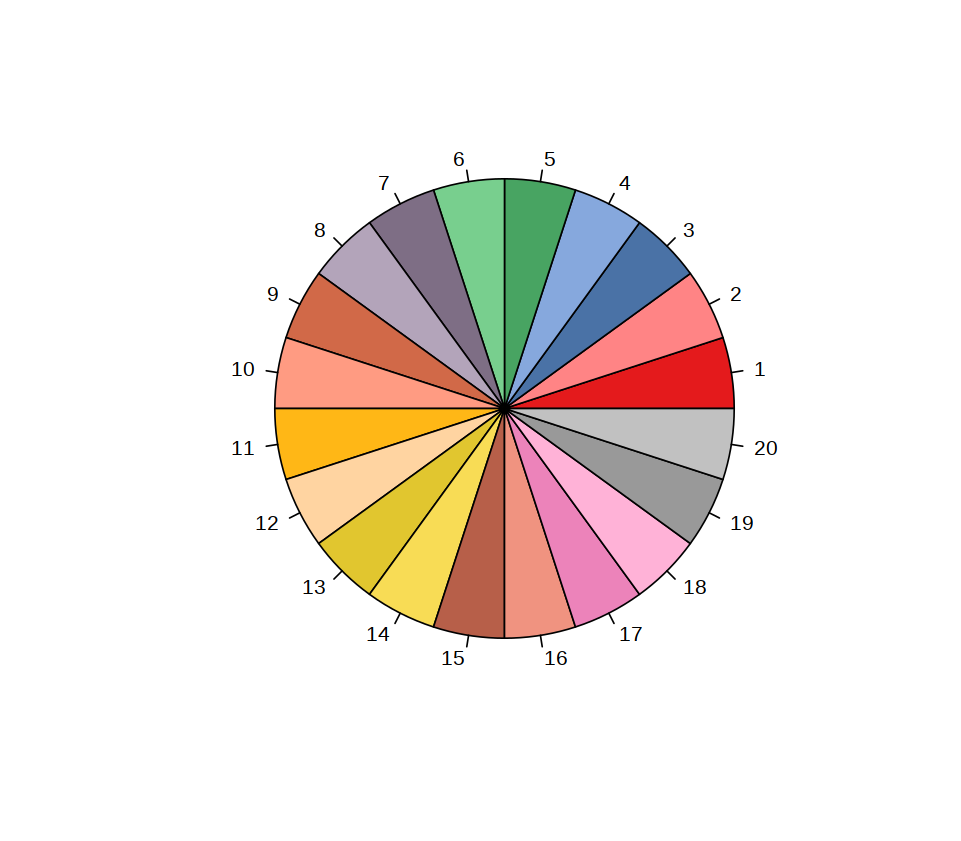

In [14]:
# make patient sample metadata and color assignments 
# http://applied-r.com/rcolorbrewer-palettes/

if (n_samples <= 4) {
    sampleColors <- brewer.pal(12, "Paired")
    sampleColors <- sampleColors[c(1,5,2,6)]
} else if (n_samples <= 12){
    sampleColors <- brewer.pal(n_samples, "Paired")
} else {
    vec_color1 <- colorRampPalette(brewer.pal(9, "Set1"))(n_samples/2)
    vec_color2 <- colorspace::lighten(vec_color1, amount=0.4) 
    sampleColors <- c(rbind(vec_color1, vec_color2))
}

sampleColors
length(sampleColors)

options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1,n_samples), col=sampleColors) 


### epi

[1] "Epithelial cells" "Epi. Non-tumor"   "LEp_prog"         "LEp_secretory"   
 [5] "LEp"              "LEp_hormone"      "BEp"              "BEp_MaSCs"       
 [9] "BEp_myo"          "Epi. Unassigned"  "Epi. Tumor"       "Normal-like"     
[13] "NBL"              "Basal"            "CLow"             "Her2E"           
[17] "LumA"             "LumB"             "Keratinocytes"

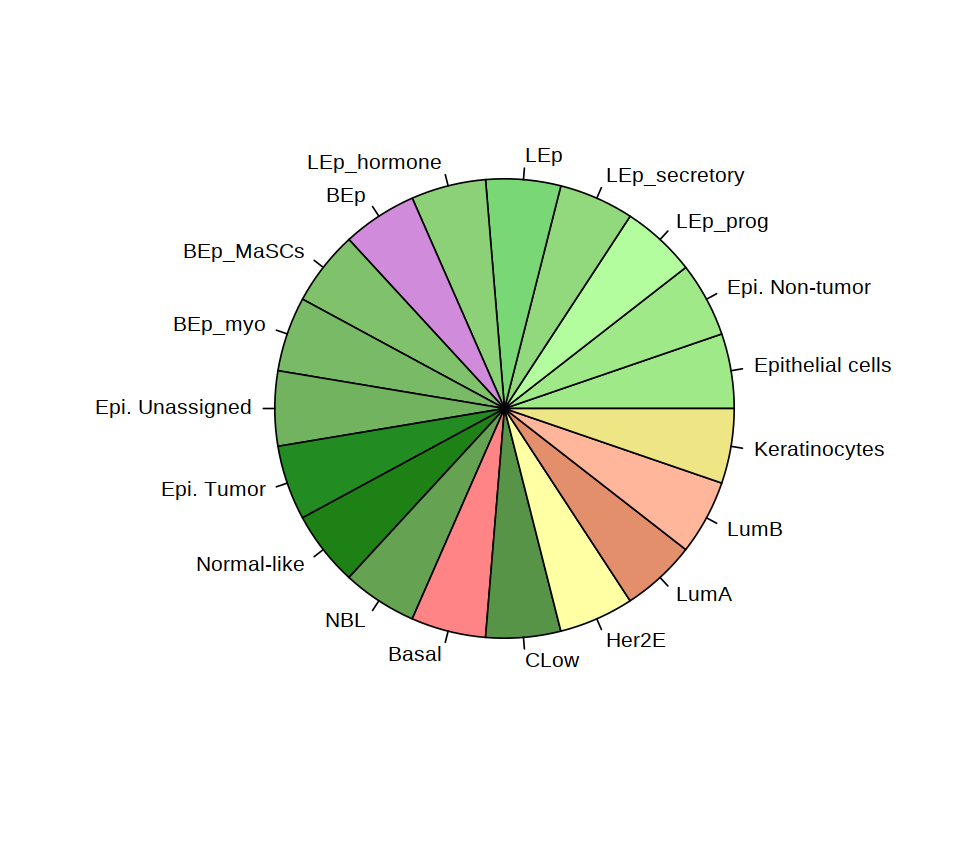

In [15]:
idx_epi <- grep(pattern_epi, names(nv_color))
names(nv_color)[idx_epi]
# http://applied-r.com/rcolorbrewer-palettes/
colors_epi <- RColorBrewer::brewer.pal(9, "Set1")
colors_epi <- colorspace::lighten(colors_epi, amount=0.4)

nv_color["Epi. Tumor"] <- "forestgreen"

nv_color["LEp_prog"] <- "#b4fd9e"
nv_color["LEp"] <- colors_epi[3]
nv_color["BEp"] <- colors_epi[4]

nv_color["Basal"] <- colors_epi[1]
nv_color["Her2E"] <- colors_epi[6]
nv_color["Her2"] <- colors_epi[6]
nv_color["LumA"] <- colors_epi[7]
nv_color["LumB"] <- colors_epi[5]
nv_color["Normal-like"] <- colorspace::darken(colors_epi[3], amount=0.4)

pie(rep(1, length(idx_epi)), col=nv_color[idx_epi],
       labels=names(nv_color)[idx_epi]) 


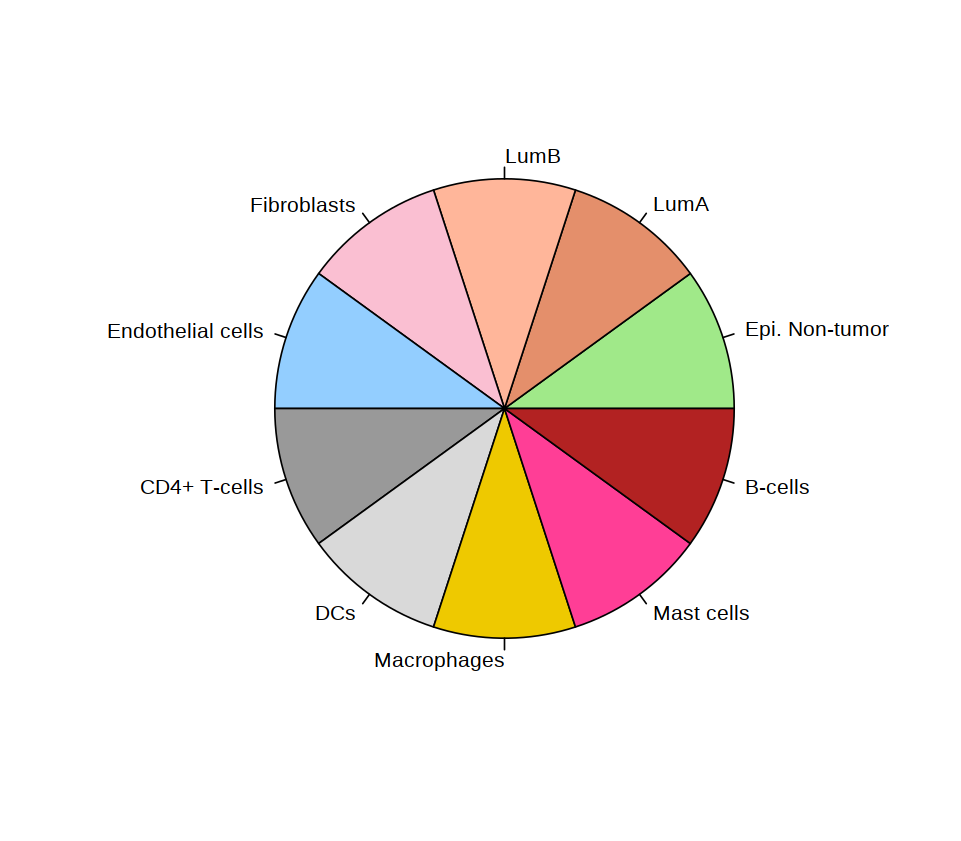

In [16]:
list_sort <- update_nv_color_cell_type(list_sort)
colors_epi <- list_sort$nv_color_cell_type

pie(rep(1, length(colors_epi)), col=colors_epi,
       labels=names(colors_epi)) 


### cell.type

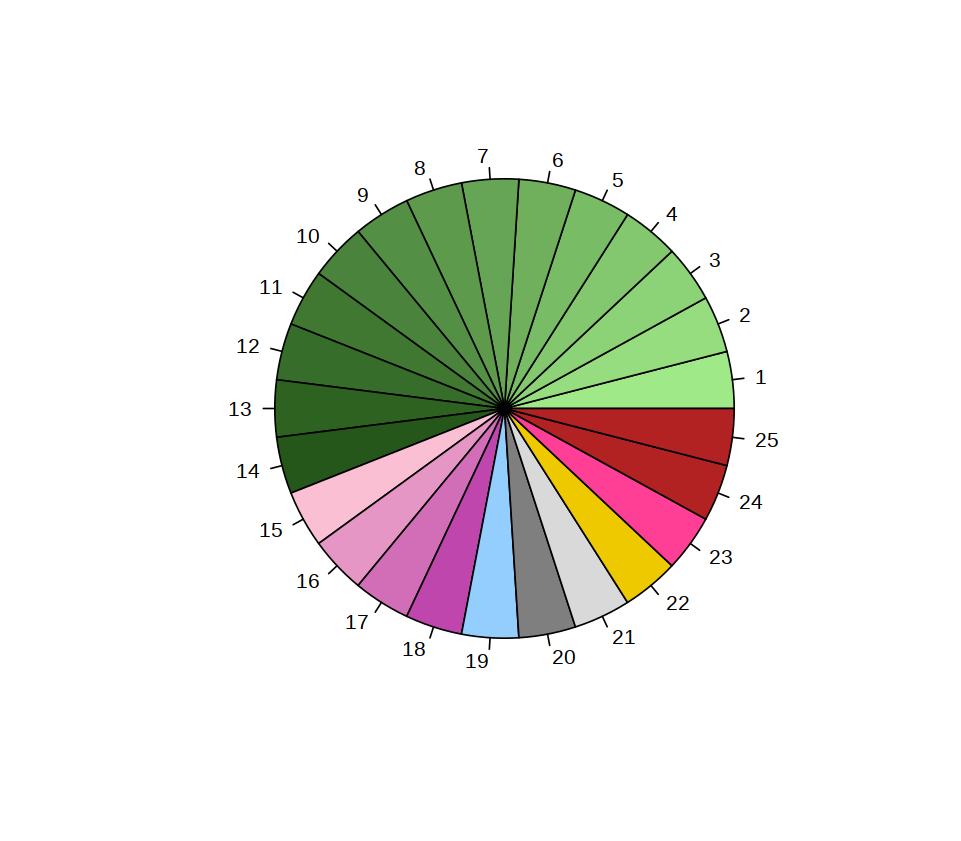

In [17]:
options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1, length(list_sort$nv_color_cluster_type_ordered)),
    col=list_sort$nv_color_cluster_type_ordered) 


# DGE

## gmt

In [18]:

list_gmt <- list()
list_gmt[["h"]] <- read.gmt("reference/gmt/h.all.v6.1.symbols.gmt")
list_gmt[["unc_lccc"]] <- read.gmt("reference/gmt/unc_lccc_human_gene_signatures.gmt")
tab_check <- "down unc_lccc"



## type_condition

In [19]:

method_dge <- "seurat_findmarkers_enricher"
dir_xlsx <- "xlsx"

list_genes_dn <- list()


# additional conditions 
genes <- NULL
str_cond1 <- NULL
str_cond_ref <- NULL
type_condition <- "none"


## tumor pairs

Tumor_01_Tamoxifen pattern_tumor_epi

assay=integrated, slot=data

Tumor_01_Tamoxifen Tumor cells n_idx1: 2082, samples: Tumor_01_Tamoxifen

Tumor_01_Control Tumor cells n_idx_ref: 2373, samples: Tumor_01_Control

seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SQLE,4.801165e-98,0.5509928,0.857,0.695,1.232747e-93,0,1.0611143,2.881164
MSMO1,1.860351e-96,0.5693242,0.838,0.643,4.776637e-92,0,1.0015069,3.383938
IDI1,4.531124e-79,0.5129234,0.801,0.594,1.163411e-74,0,0.8537717,3.423402
HMGCS1,1.053450e-64,0.5313806,0.758,0.560,2.704839e-60,0,0.8322538,3.548495
FDFT1,2.029614e-61,0.4370182,0.827,0.675,5.211236e-57,0,0.8891434,2.969535
LDLR,4.855982e-55,0.3789796,0.763,0.566,1.246822e-50,0,0.7364647,2.917957


[1] 19  8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GNAS,2.922528e-125,-0.5492901,0.999,1.000,7.503882e-121,0.0000000,2.4593666,4.057795
RPL26,6.111416e-90,-0.3420086,0.996,0.999,1.569167e-85,0.0000000,2.2885561,3.553170
RPS15A,3.575775e-71,-0.2590588,1.000,1.000,9.181160e-67,0.5672204,2.5640508,3.549038
MBD2,1.205440e-49,-0.3382330,0.698,0.782,3.095087e-45,0.0000000,0.5262313,1.981309
COX8A,6.508514e-49,-0.2640583,0.965,0.967,1.671126e-44,0.0000000,1.2943252,2.479303
RPS10,9.487061e-49,-0.2988013,0.911,0.939,2.435898e-44,0.0000000,1.0219909,2.250346


[1] 15  8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,8/10,74/4386,1.956120e-13,3.129793e-12,2.264982e-12,SQLE/IDI1/HMGCS1/FDFT1/LDLR/HMGCR/ACAT2/FDPS,8
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,5/10,200/4386,3.920990e-05,3.136792e-04,2.270047e-04,SQLE/IDI1/HMGCS1/LDLR/HMGCR,5
HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_FATTY_ACID_METABOLISM,4/10,158/4386,2.873658e-04,1.532617e-03,1.109131e-03,IDI1/HMGCS1/MIF/ACAT2,4
HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,3/10,101/4386,1.264640e-03,5.058560e-03,3.660800e-03,IDI1/HMGCS1/HMGCR,3


[1] 4 9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,7/18,290/19993,3.488608e-09,2.651342e-07,2.019720e-07,SQLE/MSMO1/IDI1/FDFT1/LDLR/HMGCR/CYP1B1,7
TNBC_Clinically_Relevant_Good.230_BCR.2011_PMID.21978456,TNBC_Clinically_Relevant_Good.230_BCR.2011_PMID.21978456,TNBC_Clinically_Relevant_Good.230_BCR.2011_PMID.21978456,3/18,216/19993,9.002076e-04,2.500732e-02,1.904990e-02,IDI1/HMGCR/FDPS,3
MM_p53null.Luminal_Genome.Biol.2013_PMID.24220145,MM_p53null.Luminal_Genome.Biol.2013_PMID.24220145,MM_p53null.Luminal_Genome.Biol.2013_PMID.24220145,3/18,223/19993,9.871312e-04,2.500732e-02,1.904990e-02,SQLE/MSMO1/HMGCR,3
Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,3/18,281/19993,1.916941e-03,3.642187e-02,2.774519e-02,SQLE/LDLR/HMGCR,3
GSEA_RESPONSE_TO_ANDROGEN_UP_NELSON,GSEA_RESPONSE_TO_ANDROGEN_UP_NELSON,GSEA_RESPONSE_TO_ANDROGEN_UP_NELSON,2/18,86/19993,2.675643e-03,4.066978e-02,3.098113e-02,IDI1/HMGCS1,2


[1] 5 9

down h

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,2/14,50/19993,0.0005471821,0.02647972,0.01725495,RPS15A/RPS10,2
Duke_Module17_pr_Mike_PMID.20335537,Duke_Module17_pr_Mike_PMID.20335537,Duke_Module17_pr_Mike_PMID.20335537,2/14,62/19993,0.0008406259,0.02647972,0.01725495,COX8A/CISH,2
Pfefferle2012_MatureLum_Adam_PMID.25575446,Pfefferle2012_MatureLum_Adam_PMID.25575446,Pfefferle2012_MatureLum_Adam_PMID.25575446,2/14,91/19993,0.0017994048,0.03119804,0.02032955,GNAS/AREG,2
Early_IRS_2_PLoS.One.2016_PMID.26991655,Early_IRS_2_PLoS.One.2016_PMID.26991655,Early_IRS_2_PLoS.One.2016_PMID.26991655,2/14,102/19993,0.0022534956,0.03119804,0.02032955,FHL2/CYTOR,2
T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,2/14,107/19993,0.0024760352,0.03119804,0.02032955,RPS10/RUNX1,2
UNC_MM_Red15_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Red15_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Red15_BMC.Med.Genomics.2011_PMID.21214954,3/14,428/19993,0.0029746242,0.03123355,0.02035269,NDUFA11/FHL2/AREG,3


[1] 6 9

filename_xlsx: xlsx/er+bc_Tumor_01_Control_vs_Tumor_01_Tamoxifen_Tumor_cells.xlsx

filename_figure: heatmap_er+bc_Tumor_01_Control_vs_Tumor_01_Tamoxifen_Tumor_cells_no_down_mcf7.e2.induced.genes_zscore

Tumor_02_Tamoxifen pattern_tumor_epi

assay=integrated, slot=data

Tumor_02_Tamoxifen Tumor cells n_idx1: 162, samples: Tumor_02_Tamoxifen

Tumor_02_Control Tumor cells n_idx_ref: 137, samples: Tumor_02_Control

seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NEAT1,3.204228e-14,1.3227917,1.000,0.978,8.227175e-10,0.9310689,3.3092678,5.566340
MSMO1,1.188591e-13,0.7508927,0.975,0.964,3.051825e-09,0.0000000,1.4233185,2.915293
SQLE,5.618182e-13,0.7584237,0.963,0.905,1.442524e-08,0.0000000,1.4279096,3.040434
NUPR1,6.000440e-13,0.8750186,0.981,0.912,1.540673e-08,-0.2046215,1.4310038,3.681843
DDIT3,5.896045e-12,0.5623255,0.920,0.664,1.513869e-07,-0.1469758,0.6046090,2.169787
SCD,1.395603e-11,0.7945767,0.821,0.606,3.583350e-07,-0.1436338,0.7166523,2.531531


[1] 28  8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SUMO2,1.344145e-09,-0.2577671,1.000,1.000,3.451226e-05,0.3980978,1.88250840,2.417313
CALML5,2.121859e-09,-0.6029752,0.506,0.766,5.448086e-05,-1.7819137,-0.03312698,1.862605
LMCD1,7.574964e-08,-0.4728546,0.556,0.774,1.944948e-03,0.0000000,0.35830510,1.821809
SYTL2,1.303229e-07,-0.4192842,0.895,0.964,3.346171e-03,0.0000000,1.16161531,2.899893
OLA1,1.415181e-07,-0.2687197,0.975,0.985,3.633620e-03,0.0000000,0.74323009,1.499023
TPM4,2.283485e-07,-0.3737720,0.988,1.000,5.863075e-03,0.0000000,2.17912141,3.771313


[1] 7 8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,10/18,74/4386,3.930468e-14,9.040077e-13,7.033470e-13,SQLE/SCD/IDI1/FDFT1/LDLR/DHCR7/TRIB3/FDPS/MVD/HMGCS1,10
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,11/18,200/4386,3.253855e-11,3.741933e-10,2.911344e-10,SQLE/NUPR1/DDIT3/SCD/INSIG1/IDI1/LDLR/DHCR7/TRIB3/HMGCS1/SLC7A11,11
HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,4/18,101/4386,6.324086e-04,4.848466e-03,3.772262e-03,SCD/INSIG1/IDI1/HMGCS1,4
HALLMARK_P53_PATHWAY,HALLMARK_P53_PATHWAY,HALLMARK_P53_PATHWAY,5/18,200/4386,9.877078e-04,5.679320e-03,4.418693e-03,NUPR1/DDIT3/TRIB3/SLC3A2/SLC7A11,5


[1] 4 9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,11/27,290/19993,5.251266e-14,4.568601e-12,2.984930e-12,MSMO1/SQLE/SCD/INSIG1/IDI1/FDFT1/LDLR/DHCR7/PPIF/SLC3A2/MCFD2,11
GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,6/27,290/19993,2.025956e-06,8.812909e-05,5.757981e-05,DDIT3/TRIB3/PPIF/SLC3A2/SLC7A11/HERPUD1,6
Duke_Module02_akt_Mike_PMID.20335537,Duke_Module02_akt_Mike_PMID.20335537,Duke_Module02_akt_Mike_PMID.20335537,4/27,77/19993,3.336515e-06,9.675892e-05,6.321817e-05,SCD/INSIG1/FDFT1/ERG28,4
Late_IRS_1_PLoS.One.2016_PMID.26991655,Late_IRS_1_PLoS.One.2016_PMID.26991655,Late_IRS_1_PLoS.One.2016_PMID.26991655,4/27,172/19993,7.953325e-05,1.729848e-03,1.130209e-03,AARS/TRIB3/SLC7A11/GARS,4
Stingl_Day7_Upregulated_Nat.Cell.Biol.2014_PMID.25173976,Stingl_Day7_Upregulated_Nat.Cell.Biol.2014_PMID.25173976,Stingl_Day7_Upregulated_Nat.Cell.Biol.2014_PMID.25173976,4/27,184/19993,1.032538e-04,1.796616e-03,1.173833e-03,SCD/PPIF/FDPS/ERG28,4
GSEA_RESPONSE_TO_ANDROGEN_UP_NELSON,GSEA_RESPONSE_TO_ANDROGEN_UP_NELSON,GSEA_RESPONSE_TO_ANDROGEN_UP_NELSON,3/27,86/19993,2.085973e-04,3.024661e-03,1.976185e-03,SCD/IDI1/HMGCS1,3


[1] 14  9

down h

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
UNC_HS_Red25_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red25_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red25_BMC.Med.Genomics.2011_PMID.21214954,2/7,143/19993,0.001042044,0.04584995,0.03071289,CALML5/HSPB1,2


[1] 1 9

filename_xlsx: xlsx/er+bc_Tumor_02_Control_vs_Tumor_02_Tamoxifen_Tumor_cells.xlsx

filename_figure: heatmap_er+bc_Tumor_02_Control_vs_Tumor_02_Tamoxifen_Tumor_cells_no_down_mcf7.e2.induced.genes_zscore

Tumor_03_Tamoxifen pattern_tumor_epi

assay=integrated, slot=data

Tumor_03_Tamoxifen Tumor cells n_idx1: 510, samples: Tumor_03_Tamoxifen

Tumor_03_Control Tumor cells n_idx_ref: 282, samples: Tumor_03_Control

seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MIF,1.353080e-47,0.6141143,0.998,0.940,3.474169e-43,0.0000000,1.407119,2.164867
SERF2,7.693850e-44,0.5041700,0.998,0.996,1.975473e-39,0.0000000,2.698809,3.769947
SUB1,3.901395e-38,0.4426218,0.998,0.982,1.001722e-33,0.0000000,1.879734,2.672953
RPL39,1.081689e-36,0.3571774,1.000,1.000,2.777344e-32,0.4184360,2.803079,3.725676
RPL29,4.178522e-35,0.3394543,1.000,1.000,1.072877e-30,1.0989850,2.978569,3.518513
RPL32,7.346668e-34,0.3222465,1.000,0.996,1.886331e-29,0.8245032,3.094483,3.635918


[1] 210   8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MTRNR2L12,9.880829e-73,-1.0375480,0.933,0.993,2.537002e-68,-0.1452255,0.65557337,2.4271997
HNRNPU,1.752774e-44,-0.5478362,0.992,1.000,4.500424e-40,0.0000000,1.35770060,2.4939842
DDX39B,1.253849e-43,-0.3258152,0.316,0.840,3.219384e-39,0.0000000,0.08692396,0.8841521
MT-ND4L,7.601837e-43,-0.9398544,0.818,0.936,1.951848e-38,-0.6374860,0.36025774,1.3835670
DDX3X,1.627912e-42,-0.5938726,0.945,0.996,4.179828e-38,0.0000000,0.87988201,2.4259611
MT-ND5,3.375745e-42,-0.6643669,0.975,0.996,8.667564e-38,-0.2055275,0.85506201,2.2605470


[1] 521   8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,25/89,200/4386,4.450196e-14,1.735576e-12,1.358481e-12,GPX4/COX6B1/UQCRB/UQCRQ/UQCR10/NDUFA3/UQCRH/COX8A/COX5B/COX6A1/NDUFB2/ATP6V1F/NDUFB7/NDUFB4/NDUFA4/COX17/NDUFA2/MGST3/ECH1/COX7A2/NDUFS8/NDUFV2/NDUFB3/COX6C/CYB5A,25
HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,9/89,49/4386,4.095412e-07,7.986054e-06,6.250892e-06,GPX4/FTL/PRDX2/NDUFB4/PRDX1/TXN/SOD1/GLRX/ATOX1,9
HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,8/89,74/4386,1.056471e-04,1.373413e-03,1.075006e-03,S100A11/FDPS/DHCR7/SCD/ECH1/SQLE/EBP/FDFT1,8
HALLMARK_ADIPOGENESIS,HALLMARK_ADIPOGENESIS,HALLMARK_ADIPOGENESIS,12/89,200/4386,6.216874e-04,6.061452e-03,4.744456e-03,GPX4/UQCRQ/UQCR10/COX8A/COX6A1/NDUFB7/DHCR7/CHCHD10/SOD1/MGST3/ECH1/CD151,12


[1] 4 9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,15/200,50/19993,9.786260e-19,2.260626e-16,1.905745e-16,RPL39/RPL32/RPL15/RPS24/RPS19/RPS28/RPL10A/RPL11/RPL5/RPL36/RPL24/RPL13/RPS9/RPL12/RPS3,15
MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,13/200,38/19993,2.947638e-17,3.404522e-15,2.870069e-15,UQCRQ/SEC61G/TMA7/SEC61B/COX8A/COX5B/COX6A1/NDUFB2/POMP/COX17/TXN/COX7A2/DYNLL1,13
MRibosomal_BMC.Med.Genomics.2011_PMID.21214954,MRibosomal_BMC.Med.Genomics.2011_PMID.21214954,MRibosomal_BMC.Med.Genomics.2011_PMID.21214954,10/200,23/19993,8.177920e-15,6.296999e-13,5.308475e-13,RPL39/RPL18A/RPS24/RPL41/RPL10/RPL26/RPL36/RPL13/RPS25/RPS3,10
JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,10/200,35/19993,1.182487e-12,6.828861e-11,5.756843e-11,HSPE1/SEC61G/RPL13/COX8A/ELOB/NOP10/RPS27L/RNH1/ADIRF/JUND,10
GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,15/200,277/19993,1.350897e-07,6.241146e-06,5.261390e-06,S100A11/VAMP8/HSPB1/TSTD1/OCIAD2/SQOR/FXYD3/DUSP23/SMIM22/ADIRF/AGR2/HSPA1A/S100A14/CYP1B1/MT2A,15
MITO2_BMC.Med.Genomics.2011_PMID.21214954,MITO2_BMC.Med.Genomics.2011_PMID.21214954,MITO2_BMC.Med.Genomics.2011_PMID.21214954,8/200,78/19993,1.122555e-06,4.321838e-05,3.643381e-05,RPL36AL/HSPE1/LAMTOR5/SNRPG/SUMO1/NDUFA4/NDUFB3/TMEM59,8


[1] 23  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,28/202,200/4386,7.264656e-08,3.559681e-06,2.982332e-06,HNRNPU/PABPC1/RAD23B/GSPT1/HNRNPC/DDX21/HSP90AB1/CUL1/UBA2/SYNCRIP/IARS/YWHAE/TRA2B/KPNB1/SERBP1/HNRNPR/HDGF/ETF1/RSL1D1/EPRS/EIF4G2/DDX18/IFRD1/CCT5/HNRNPA2B1/CANX/DEK/HSPD1,28
HALLMARK_MITOTIC_SPINDLE,HALLMARK_MITOTIC_SPINDLE,HALLMARK_MITOTIC_SPINDLE,25/202,200/4386,3.381059e-06,8.283594e-05,6.940068e-05,CLIP1/VCL/EZR/LRPPRC/NF1/CD2AP/PALLD/KIF1B/MYO1E/PAFAH1B1/YWHAE/HOOK3/ROCK1/TRIO/CSNK1D/PDLIM5/SPTAN1/MYH9/RASA2/ARHGEF12/DST/WASL/PCGF5/DLG1/RASAL2,25
HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_DN,18/202,144/4386,8.685136e-05,1.240184e-03,1.039037e-03,NFKB1/NIPBL/MIOS/TJP1/PDLIM5/ATXN1/ATRX/INPP4B/CDKN1B/RASA2/YTHDC1/LAMC1/F3/DLG1/NR3C1/RUNX1/ATP2B1/CYR61,18
HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,22/202,200/4386,1.012395e-04,1.240184e-03,1.039037e-03,HNRNPU/RAD23B/GSPT1/NUP98/CUL3/NCL/PRPF4B/CUL1/SYNCRIP/PAFAH1B1/ILF3/TRA2B/KPNB1/SFPQ/SLC38A1/TOP1/ATRX/CDKN1B/YTHDC1/RASAL2/AMD1/HIF1A,22
HALLMARK_HEME_METABOLISM,HALLMARK_HEME_METABOLISM,HALLMARK_HEME_METABOLISM,19/202,200/4386,1.880689e-03,1.535896e-02,1.286787e-02,USP15/BACH1/VEZF1/GAPVD1/PICALM/ELL2/TFRC/ADD1/HDGF/RIOK3/TOP1/DAAM1/GCLC/ARHGEF12/CAST/NR3C1/TCEA1/TRIM58/CDR2,19
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,19/202,200/4386,1.880689e-03,1.535896e-02,1.286787e-02,SYTL2/TBK1/PITPNB/HSPA4/TFRC/STIP1/ETF1/TXNRD1/EPRS/ACTR3/GCLC/ACSL3/PPP1R15A/IFRD1/TCEA1/CANX/TES/HSPD1/CCT6A,19


[1] 8 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
UNC_HS_Green16_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green16_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green16_BMC.Med.Genomics.2011_PMID.21214954,63/503,276/19993,4.242109e-42,1.382928e-39,1.058295e-39,HNRNPU/NRIP1/CLIP1/ZNF91/SMG1/CHD1/AHCTF1/TBK1/TRIP11/CCNL1/RANBP2/SLK/NCL/NIPBL/FNBP4/CEP350/SETX/MBNL1/USP47/GOLGA4/TPR/PNN/DSP/SF3B1/CD2AP/MAP4K5/CHD9/ROCK2/DICER1/ZNF43/BTBD7/SLC4A7/BAZ1A/ZNF267/RBM25/NKTR/EEA1/LPGAT1/SCAF11/DAAM1/ANKRD12/JMJD1C/CCDC186/GOLGB1/RB1CC1/SMCHD1/ANKRD11/BRWD1/BAZ2B/RSF1/PPP1R12A/SUZ12/DNTTIP2/ITGB1/LSM14A/TMF1/HNRNPA2B1/DEK/HNRNPDL/ATP2B1/TAX1BP1/RSRC2/CHML,63
Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,48/503,281/19993,3.525587e-26,5.746707e-24,4.397706e-24,NRIP1/VCL/BACH1/MACF1/CCNL1/ZNF148/KMT2A/CSNK1A1/CEP350/SPEN/STRN3/MCL1/FRYL/CAB39/MYO1E/CAMSAP2/TRIO/TJP1/MED13/ATXN1/KMT5B/DAAM1/INPP4B/MORC3/SMURF1/KDM5B/RAB11FIP1/GCLC/ZNF217/F3/DST/NPEPPS/DLG1/FEM1B/CD44/NAV2/AHNAK/NR3C1/ACBD3/CFLAR/MIR22HG/UGCG/MAST4/SVIL/KLF6/LRRFIP2/SOX9/RBMS1,48
UNC_Unknown_4_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_4_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_4_BMC.Med.Genomics.2011_PMID.21214954,23/503,68/19993,2.807051e-20,3.050329e-18,2.334284e-18,RBM39/TRIP11/CCNL1/KHDC4/FNBP4/USP47/GOLGA4/PNN/CD2AP/ZNF43/NKTR/ANKRD12/JMJD1C/GOLGB1/RB1CC1/BRWD1/SENP6/BAZ2B/DNTTIP2/TMF1/HNRNPDL/TAX1BP1/RSRC2,23
UNC_Unknown_6_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_6_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_6_BMC.Med.Genomics.2011_PMID.21214954,20/503,55/19993,1.588226e-18,1.294404e-16,9.905514e-17,RBM39/TRIP11/CCNL1/KHDC4/FNBP4/USP47/GOLGA4/PNN/CD2AP/ZNF43/NKTR/ANKRD12/JMJD1C/RB1CC1/BAZ2B/DNTTIP2/TMF1/HNRNPDL/TAX1BP1/RSRC2,20
UNC_MM_Green17_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Green17_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Green17_BMC.Med.Genomics.2011_PMID.21214954,29/503,149/19993,7.392429e-18,4.819863e-16,3.688433e-16,ASH1L/EIF3A/ZNF148/BDP1/FUS/TPR/BRD1/CLOCK/TRIM56/KIF1B/XIST/WAPL/U2SURP/MED13/PRPF38B/EEA1/LPGAT1/CSDE1/G3BP2/CHD4/CCDC186/GOLGB1/RIOK1/RB1CC1/GCLC/BAZ2B/NPEPPS/AKAP9/RUNX1,29
Taube_EMT_down_PNAS.2010_PMID.20713713,Taube_EMT_down_PNAS.2010_PMID.20713713,Taube_EMT_down_PNAS.2010_PMID.20713713,41/503,447/19993,9.448779e-13,4.726040e-11,3.616634e-11,PABPC1/GSPT1/YWHAZ/RRN3/CHD1/NFKB1/SLK/DIAPH1/DDX21/HSP90AB1/LRPPRC/DSP/CD2AP/COBLL1/FRYL/DICER1/CAB39/TSC22D2/WDR3/CAMSAP2/RSL1D1/TXNRD1/TAF1D/SYBU/PSME4/DAAM1/MAP7/GCLC/DDX18/MYO5C/F3/DST/PPP2R2A/ATP6V1H/CAST/DNTTIP2/CD44/ZFAND5/PLCG2/ABLIM1/CHMP2B,41


[1] 58  9

filename_xlsx: xlsx/er+bc_Tumor_03_Control_vs_Tumor_03_Tamoxifen_Tumor_cells.xlsx

filename_figure: heatmap_er+bc_Tumor_03_Control_vs_Tumor_03_Tamoxifen_Tumor_cells_zscore

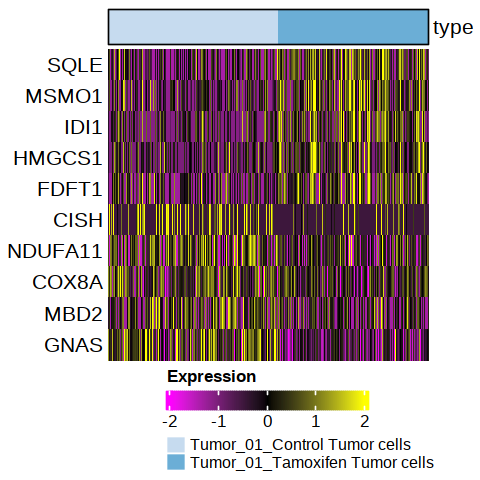

Tumor_04_Tamoxifen pattern_tumor_epi

assay=integrated, slot=data

Tumor_04_Tamoxifen Tumor cells n_idx1: 26, samples: Tumor_04_Tamoxifen

Tumor_04_Control Tumor cells n_idx_ref: 56, samples: Tumor_04_Control

Tumor_04_Tamoxifen Tumor cells nrow(markers)=0

Tumor_05_Tamoxifen pattern_tumor_epi

assay=integrated, slot=data

Tumor_05_Tamoxifen Tumor cells n_idx1: 1684, samples: Tumor_05_Tamoxifen

Tumor_05_Control Tumor cells n_idx_ref: 2239, samples: Tumor_05_Control

seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MALAT1,0.000000e+00,1.4973814,0.999,0.996,0.000000e+00,-0.3631055,5.771631,7.418852
HSPA5,4.995468e-240,1.3297663,0.990,0.931,1.282636e-235,-0.6163655,1.836397,4.969793
MAP1LC3B,2.371955e-231,0.9312791,0.975,0.823,6.090233e-227,0.0000000,1.569530,3.273607
HSP90B1,4.520701e-222,1.0183945,0.994,0.957,1.160735e-217,-0.3773733,1.884364,3.997878
NEAT1,8.355021e-219,1.5465818,0.990,0.927,2.145235e-214,0.0000000,3.282833,5.853036
DNAJC3,2.401673e-214,0.8133480,0.946,0.711,6.166536e-210,-0.3848863,1.014887,2.505421


[1] 391   8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CCND1,1.654617e-289,-2.077374,0.201,0.735,4.248395e-285,0,0.2885324,4.480904
ACTB,1.295313e-283,-1.062260,0.995,1.000,3.325845e-279,0,3.5868312,5.553335
KRT7,1.890079e-235,-1.443897,0.817,0.971,4.852967e-231,0,1.8776338,4.633991
EDN1,6.977456e-231,-1.787562,0.219,0.749,1.791532e-226,0,0.3564117,3.845257
ACTN1,2.793145e-224,-1.182540,0.607,0.910,7.171680e-220,0,0.7723504,3.088063
TPM1,1.447323e-217,-1.274348,0.723,0.968,3.716147e-213,0,1.6768137,4.896681


[1] 756   8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,36/176,200/4386,4.179983e-15,1.755593e-13,1.319995e-13,HSPA5/HSP90B1/TXNRD1/SQSTM1/SLC7A11/SERP1/CANX/HSPA9/DDIT3/HMGCS1/CALR/PPP1R15A/INSIG1/ASNS/XBP1/FAM129A/SLC6A6/TES/RPN1/SDF2L1/NUPR1/PRDX1/PHGDH/CDKN1A/UFM1/RAB1A/DDIT4/HMGCR/IDI1/EPRS/TCEA1/USO1/RIT1/LDLR/DAPP1/TRIB3,36
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,26/176,113/4386,1.034224e-13,2.171870e-12,1.632985e-12,HSPA5/HSP90B1/DNAJC3/HERPUD1/DNAJB9/ATF3/EIF2AK3/SERP1/HYOU1/HSPA9/WIPI1/CHAC1/CALR/TARS/SEC31A/ASNS/XBP1/BAG3/TSPYL2/ATF4/CEBPG/PDIA6/DDIT4/SPCS3/CEBPB/ATP6V0D1,26
HALLMARK_PROTEIN_SECRETION,HALLMARK_PROTEIN_SECRETION,HALLMARK_PROTEIN_SECRETION,15/176,96/4386,4.711355e-06,6.595898e-05,4.959322e-05,SEC24D/GOLGA4/ARF1/RAB5A/TMED2/RAB2A/SEC31A/COPB2/LMAN1/ARFGAP3/VPS4B/CLTC/COPB1/ARCN1/USO1,15
HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,22/176,200/4386,1.167744e-05,1.226131e-04,9.219032e-05,SQSTM1/ATF3/PNRC1/MAFF/PPP1R15A/EIF1/BTG1/HBEGF/DNAJB4/GEM/NFE2L2/CDKN1A/NFAT5/CEBPB/IL6ST/KDM6B/MXD1/LDLR/GADD45A/EGR1/TSC22D1/SAT1,22
HALLMARK_P53_PATHWAY,HALLMARK_P53_PATHWAY,HALLMARK_P53_PATHWAY,21/176,200/4386,3.820584e-05,2.820505e-04,2.120681e-04,SLC3A2/ATF3/SLC7A11/DDIT3/PPP1R15A/HMOX1/TSPYL2/BTG1/HBEGF/NUPR1/MXD4/SEC61A1/CDKN1A/DDIT4/RGS16/CCNK/MXD1/GADD45A/TRIB3/TSC22D1/SAT1,21
HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,14/176,101/4386,4.029293e-05,2.820505e-04,2.120681e-04,SLC38A2/DNAJB9/SEC24D/PGM3/HMGCS1/INSIG1/LMAN1/UBE2J1/HMGCR/SPCS3/IDI1/UAP1/TSC22D1/SAT1,14


[1] 11  9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,44/382,430/19993,8.132572e-20,2.708146e-17,2.080226e-17,MAP1LC3B/HSP90B1/TXNRD1/DNAJB9/GFPT1/MIR22HG/CSGALNACT2/ARL8B/SEC24D/EIF2AK3/SERP1/HSPA13/SUCO/MCFD2/SEC61B/TMED5/TARS/ACBD3/CALCOCO2/SRP54/TCEAL9/SEC61G/COPB2/ABHD5/H2AFZ/ATF2/JMJD1C/CHMP2B/DNAJA1/RAB21/ARFGAP3/EIF1B/UFM1/BNIP2/SPCS3/IDI1/SARAF/FAM3C/GHITM/COPB1/CLINT1/ARCN1/USO1/LAMTOR3,44
Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,15/382,27/19993,1.773253e-19,2.952465e-17,2.267897e-17,MAP1LC3B/HERPUD1/SLC38A2/SLC3A2/DNAJB9/HBP1/KLHL24/HYOU1/SEL1L/CALU/SDF2L1/DDIT4/EPRS/SETX/SAT1,15
GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,35/382,290/19993,3.172227e-18,3.521172e-16,2.704741e-16,HSPA5/HERPUD1/SLC3A2/ERO1B/DNAJB9/ATF3/SLC7A11/SEC24D/SERP1/MAFF/HSPA9/DDIT3/CHAC1/PDIA3/CLK1/CALR/PPP1R15A/PDIA4/HMOX1/SLC38A1/XBP1/IL6R/BAG3/ATF4/DNAJB4/CEBPG/UBE2J1/CRELD2/CEBPB/DDX17/PPIF/SFPQ/GADD45A/TRIB3/HSPA6,35
UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,36/382,335/19993,4.569742e-17,3.804310e-15,2.922230e-15,MAP1LC3B/GCLM/MBNL2/CANX/STX3/PGM3/PJA2/TRAM1/ARF1/PDIA3/SRPRA/RAB5A/TMED2/TMCO3/ARF4/HSP90AB1/CALU/JUND/LMAN1/G3BP2/PSAP/P4HB/DNAJB4/EHF/TLN1/NFE2L2/DNAJA1/MAPRE1/CDV3/CLDND1/RAB1A/DDX3X/PPIB/ZNF207/PPIF/DNAJA2,36
XBP1_Signature_Nature.2014_PMID.24670641,XBP1_Signature_Nature.2014_PMID.24670641,XBP1_Signature_Nature.2014_PMID.24670641,13/382,70/19993,6.549063e-10,4.361676e-08,3.350363e-08,DNAJB9/MAFG/DDIT3/ZNF292/RSRC2/XBP1/SLC6A6/SDF2L1/LTN1/EPRS/DDX17/SETX/RIT1,13
Inflammatory_Breast_Cancer_491_nIBC_CCR.2013_PMID.23396049,Inflammatory_Breast_Cancer_491_nIBC_CCR.2013_PMID.23396049,Inflammatory_Breast_Cancer_491_nIBC_CCR.2013_PMID.23396049,22/382,234/19993,8.906014e-10,4.942838e-08,3.796774e-08,DNAJB9/SERP1/CANX/HSPA9/PDIA4/DNAJC12/ARF4/CALU/RPN1/COPG1/ATF2/FEM1C/CHMP2B/NFE2L2/HNRNPU/TPBG/DDX3X/TMEM41B/PAK2/SFPQ/GPBP1L1/MLF1,22


[1] 69  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,49/343,200/4386,8.331466e-14,4.165733e-12,3.595686e-12,LSM2/C1QBP/NME1/RPS2/SNRPD1/LDHA/PA2G4/RANBP1/TUFM/AIMP2/NOP16/ACP1/RPL6/SRSF7/SRM/CYC1/RAN/TXNL4A/CCT7/ODC1/XPO1/SRSF3/CCT3/ERH/MRPS18B/HDDC2/HNRNPD/RUVBL2/PSMA7/APEX1/NHP2/PHB2/VDAC3/COX5A/NDUFAB1/CLNS1A/FAM120A/NOP56/POLD2/UBE2E1/SSBP1/SNRPD2/VDAC1/IMPDH2/PHB/SSB/SNRPA1/PRDX3/SYNCRIP,49
HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,37/343,200/4386,4.028533e-07,6.714222e-06,5.795434e-06,ATP1B1/NDUFV2/MRPL34/LDHA/MDH2/TIMM8B/HSD17B10/MRPL15/CYC1/TIMM13/NDUFB7/TOMM22/ECH1/CYB5A/MTX2/SDHC/COX6B1/MRPS15/PHB2/VDAC3/COX5A/NDUFAB1/BAX/NDUFV1/NDUFS3/NDUFS8/ECHS1/COX5B/GPI/VDAC2/HTRA2/VDAC1/NDUFB3/UQCRQ/NDUFS6/SLC25A5/PRDX3,37
HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,37/343,200/4386,4.028533e-07,6.714222e-06,5.795434e-06,CCND1/EDN1/DUSP4/PHLDA1/LIF/CYR61/TNFAIP3/LAMB3/CFLAR/SOCS3/F3/FJX1/IER3/PMEPA1/RCAN1/ICAM1/PDLIM5/NINJ1/BIRC3/SMAD3/PDE4B/EHD1/KLF10/DUSP1/RHOB/JAG1/GADD45B/ETS2/IFNGR2/TNIP2/CLCF1/SOD2/KLF2/SDC4/PLAUR/CEBPD/FOSL1,37
HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TGF_BETA_SIGNALING,12/343,54/4386,7.307082e-04,9.133852e-03,7.883957e-03,ID1/PMEPA1/BCAR3/ID3/SMAD3/KLF10/FKBP1A/IFNGR2/THBS1/RAB31/PPP1CA/CDH1,12
HALLMARK_APOPTOSIS,HALLMARK_APOPTOSIS,HALLMARK_APOPTOSIS,23/343,161/4386,3.094346e-03,3.094346e-02,2.670909e-02,CCND1/TXNIP/CFLAR/HSPB1/IER3/KRT18/GSN/TSPO/RARA/BIRC3/DFFA/BAX/DAP3/NEDD9/VDAC2/BCAP31/RHOB/GADD45B/IFITM3/SOD2/H1F0/TGFB2/CLU,23


[1] 5 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,54/732,277/19993,2.638762e-24,8.718815e-22,6.240836e-22,KRT7/EDN1/KRT19/ATP1B1/S100A16/KRT80/SQOR/CITED4/LAD1/RHOV/HSPB1/KRT18/S100A6/ID1/TSPAN15/TACSTD2/PKP3/DSTN/MGLL/ZNF593/KCNMA1/GATA3/MLPH/KRT8/EIF6/MYOF/TPD52/CLDN3/RER1/ZG16B/IMP4/FOXA1/ELF3/S100A11/CD24/CEACAM6/NCEH1/CRIP2/SPNS2/CLDN7/CAPNS1/SPINT1/S100A14/TMEM45B/KCNK6/RBM47/CA12/FXYD3/ADIRF/VAMP8/CLU/CD9/SCGB2A2/CLDN4,54
Stromal_Down_Nat.Med.2009_PMID.19648928,Stromal_Down_Nat.Med.2009_PMID.19648928,Stromal_Down_Nat.Med.2009_PMID.19648928,60/732,347/19993,4.954634e-24,8.718815e-22,6.240836e-22,KRT7/EDN1/ACTN1/TPM1/ACTG1/CDCP1/MYH9/CITED4/LAD1/CBLC/TFAP2A/LAMB3/LAMC2/PALLD/SOX9/GALE/C7orf50/PDCD2L/SURF2/FAM173A/RAB25/TACSTD2/HPCAL1/TSPO/PKP3/GATA3/KRT8/SLC25A39/PDLIM5/PPP1R14B/FLNB/FBLIM1/MREG/CNN2/TPD52/ARHGAP29/NCEH1/NEDD9/DAPK3/MEAF6/CLDN7/ITGB8/ITGA6/SPINT1/LSR/S100A14/SYBU/EZR/RHOD/CXCL16/SDC4/PLPP2/VAMP8/NAV2/DSG2/CDH1/CD151/CD9/SERINC2/STC2,60
Duke_Module13_myc_Mike_PMID.20335537,Duke_Module13_myc_Mike_PMID.20335537,Duke_Module13_myc_Mike_PMID.20335537,58/732,326/19993,6.539111e-24,8.718815e-22,6.240836e-22,C1QBP/NME1/SNRPD1/RRS1/PA2G4/FJX1/RANBP1/TUFM/AIMP2/EBNA1BP2/NOP16/KRT18/ENO1/MAT2A/TRAP1/HSD17B10/ATIC/PTMA/COA4/MRPL15/SRSF7/SRM/STEAP1/RAN/AIMP1/MRPL3/RRP1B/ODC1/TIMM13/CCT3/UBE2N/RUVBL2/EEF1E1/JPT1/CTPS1/OXLD1/APEX1/MRPS35/IMP4/FARSA/EIF3M/PSMG1/CLNS1A/EXOSC4/NOP56/IFRD2/MRTO4/VDAC1/IMPDH2/PHB/SSB/DKC1/PRMT1/PDCD2/SNRPA1/SYNCRIP/FKBP4/STC2,58
UNC_MM_Red16_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Red16_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Red16_BMC.Med.Genomics.2011_PMID.21214954,56/732,440/19993,3.645454e-16,3.645454e-14,2.609377e-14,KRT19/PFN1/MRPL12/PTGES2/MRPL4/TRIM47/TSFM/LSM4/ATIC/MRPS34/CAPZB/DBNL/PKM/SRM/HRAS/NR2F6/POLDIP2/BCL7C/ARF6/SSBP4/DUS1L/TIMM13/NOB1/PGLS/VPS72/CCT3/RUVBL2/SNF8/NAA10/SMARCB1/ENDOG/TUBG1/ZNHIT2/UBTF/SMARCA4/MAP3K20/FARSA/FBXL15/PHB2/AP2M1/ELF3/NDUFV1/AKT1/SOX4/MRTO4/PRELID1/GIPC1/LSR/PRMT1/PHF23/LRP10/PLXNB2/IGFBP2/PPP1CA/CEBPD/SERINC2,56
Claudin_Low_Genome.Biol.2007_PMID.17493263,Claudin_Low_Genome.Biol.2007_PMID.17493263,Claudin_Low_Genome.Biol.2007_PMID.17493263,38/732,244/19993,3.971737e-14,3.177390e-12,2.274342e-12,KRT19/EPPK1/SOX9/ENAH/METRN/KRT18/RAB25/TACSTD2/PKP3/GATA3/NAXE/MUC1/SLC20A2/GGCT/TPD52/EFHD1/CLDN3/ZG16B/PAFAH1B3/DDAH1/FOXA1/ELF3/POLR2H/HACD3/CLDN7/SPINT1/GOLM1/S100A14/IRX3/PON2/FXYD3/H1F0/FKBP4/IGFBP2/CDH1/CD9/SERINC2/CLDN4,38
Duke_Module18_ras_Mike_PMID.20335537,Duke_Module18_ras_Mike_PMID.20335537,Duke_Module18_ras_Mike_PMID.20335537,29/732,168/19993,3.102499e-12,2.068333e-10,1.480491e-10,PHLDA1/ZFP36L2/FJX1/POLR3K/TUBB/IER3/ENO1/ID1/MAT2A/PTMA/MRPL15/SERPINB1/ODC1/MRPL17/BRIX1/MRPL57/CYB5A/EEF1E1/GAL/NOP56/KLF10/SOWAHC/DUSP1/VDAC1/HEBP1/DKC1/SYNCRIP/PLAUR/RAB31,29


[1] 95  9

filename_xlsx: xlsx/er+bc_Tumor_05_Control_vs_Tumor_05_Tamoxifen_Tumor_cells.xlsx

filename_figure: heatmap_er+bc_Tumor_05_Control_vs_Tumor_05_Tamoxifen_Tumor_cells_zscore

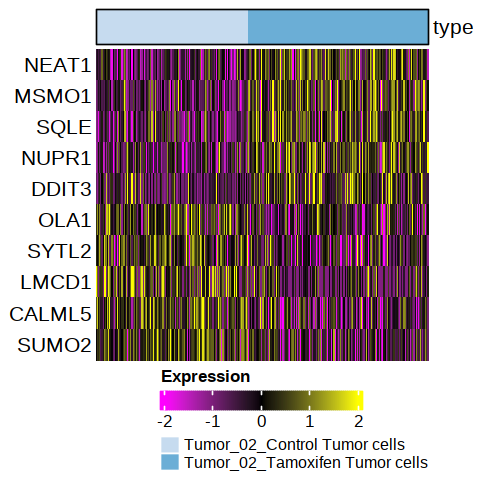

Tumor_06_Tamoxifen pattern_tumor_epi

assay=integrated, slot=data

Tumor_06_Tamoxifen Tumor cells n_idx1: 2219, samples: Tumor_06_Tamoxifen

Tumor_06_Control Tumor cells n_idx_ref: 2929, samples: Tumor_06_Control

seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SESN2,0,0.6423052,0.742,0.199,0,-0.1323633,0.5081074,2.241963
ATF3,0,1.0552718,0.809,0.275,0,0.0000000,1.1100328,5.079583
SLC7A11,0,1.4414331,0.638,0.172,0,0.0000000,0.8950773,3.180295
HMGCS1,0,1.4735439,0.760,0.326,0,0.0000000,1.1294320,3.746745
HSPA5,0,2.0293841,0.989,0.809,0,-0.1348062,2.1476327,4.255680
SLC3A2,0,1.0015972,0.999,0.913,0,0.0000000,2.4690224,3.867752


[1] 430   8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KRT8,0.000000e+00,-0.9364293,0.975,0.999,0.000000e+00,0.000000,2.7340645,5.279474
KRT19,0.000000e+00,-0.9852478,0.952,0.995,0.000000e+00,0.000000,3.5819557,6.050775
CCND1,1.035371e-298,-1.3446454,0.490,0.801,2.658419e-294,0.000000,0.6086928,2.872417
ACTB,1.679209e-278,-0.8702452,0.977,1.000,4.311537e-274,0.000000,3.6232761,6.167586
MYL6,2.086992e-267,-0.5772319,1.000,1.000,5.358560e-263,1.544785,3.2785192,4.667886
PARK7,6.560333e-262,-0.5426771,0.981,0.998,1.684431e-257,0.000000,1.2893523,2.483151


[1] 398   8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,46/194,200/4386,4.386639e-22,2.017854e-20,1.523780e-20,SLC7A11/HMGCS1/HSPA5/DDIT3/HSP90B1/TRIB3/SQSTM1/FAM129A/ASNS/INSIG1/IDI1/SERP1/LDLR/HMGCR/TCEA1/HSPA9/PPP1R15A/SQLE/EPRS/NUPR1/DDIT4/SDF2L1/TXNRD1/MTHFD2/PHGDH/IFRD1/GOT1/DHCR7/SCD/CDKN1A/CALR/CANX/NAMPT/USO1/SLC1A5/EIF2S2/FKBP2/WARS/TMEM97/RAB1A/RDH11/GCLC/TES/SLC6A6/ATP2A2/DAPP1,46
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,30/194,113/4386,2.336870e-16,5.374801e-15,4.058774e-15,ATF3/HSPA5/HSP90B1/HERPUD1/DNAJB9/ASNS/HYOU1/SERP1/CEBPG/HSPA9/ATF4/DDIT4/EIF4EBP1/DNAJC3/MTHFD2/DDX10/EIF2AK3/XPOT/CALR/CHAC1/VEGFA/CEBPB/PDIA6/SEC31A/SPCS3/WIPI1/IARS/STC2/TARS/ATF6,30
HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,32/194,200/4386,7.718150e-11,1.183450e-09,8.936805e-10,ATF3/BTG1/SQSTM1/LDLR/PPP1R15A/KLF6/HBEGF/DUSP1/TSC22D1/MAFF/TGIF1/CDKN1A/GADD45A/VEGFA/MYC/NAMPT/CEBPB/NFE2L2/ATP2B1/KDM6B/MXD1/SAT1/TRIB1/DUSP5/JUN/IRF1/GADD45B/PHLDA2/TNIP1/ETS2/ZFP36/JUNB,32
HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,18/194,74/4386,1.574877e-09,1.811109e-08,1.367657e-08,ATF3/HMGCS1/TRIB3/FAM129A/IDI1/LDLR/HMGCR/SQLE/STX5/MVD/DHCR7/SCD/FDPS/ERRFI1/TMEM97/FDFT1/HSD17B7/ANXA5,18
HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,25/194,200/4386,1.590078e-06,1.462872e-05,1.104686e-05,ATF3/HSPA5/DDIT3/BTG1/HMOX1/MT2A/PPP1R15A/KLF6/DDIT4/DUSP1/MAFF/MT1E/KLHL24/CDKN1A/VEGFA/HDLBP/ZNF292/BNIP3L/ERRFI1/TES/SLC6A6/JUN/STC2/FOXO3/ZFP36,25
HALLMARK_P53_PATHWAY,HALLMARK_P53_PATHWAY,HALLMARK_P53_PATHWAY,23/194,200/4386,1.771266e-05,1.357971e-04,1.025470e-04,ATF3/SLC7A11/SLC3A2/DDIT3/BTG1/TRIB3/HMOX1/PPP1R15A/NUPR1/DDIT4/HBEGF/TSC22D1/CDKN1A/GADD45A/SEC61A1/SFN/MXD1/SAT1/XPC/JUN/TPD52L1/MKNK2/FOXO3,23


[1] 11  9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,22/421,27/19993,5.528248e-33,1.829850e-30,1.315141e-30,SLC3A2/HERPUD1/DNAJB9/HYOU1/MAP1LC3B/EPRS/DDIT4/SDF2L1/SEL1L/CALU/CLIC4/IFRD1/KLHL24/SLC38A2/SEC63/TMEM106B/NFE2L1/WARS/YARS/SAT1/CARS/SETX,22
UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,46/421,430/19993,9.647209e-20,1.596613e-17,1.147510e-17,HSP90B1/DNAJB9/GFPT1/HSPA13/IDI1/SERP1/SEC24D/MAP1LC3B/TXNRD1/CALCOCO2/MTHFD2/MCFD2/BET1/EIF2AK3/XPOT/CSGALNACT2/CCPG1/MAPK6/SUCO/KDELR2/ATF2/USO1/CYCS/JMJD1C/TMEM106B/TMED5/EIF5/ARCN1/RSL24D1/THAP1/PPP1CB/SPCS3/RNF6/SEC61G/SEC22B/SLK/ABI1/SARAF/SCFD1/ARFGAP3/SRP54/PTS/TARS/FAM3C/MIR22HG/TIMM17A,46
GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,36/421,290/19993,9.536057e-18,1.052145e-15,7.561926e-16,ATF3/SLC7A11/HSPA5/SLC3A2/DDIT3/HERPUD1/TRIB3/DNAJB9/SERP1/SEC24D/HMOX1/CEBPG/HSPA9/PPP1R15A/ATF4/PDIA3/MAFF/PPIF/PDIA4/CCPG1/CALR/GADD45A/CRELD2/PMAIP1/CHAC1/MYC/CEBPB/CBX4/NFE2L1/EIF5/KLHL21/IL6R/TIMM44/UBE2J1/SLC38A1/DESI2,36
Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,34/421,281/19993,1.768378e-16,1.463333e-14,1.051720e-14,BTG1/LDLR/HMGCR/SQLE/KLF6/DDIT4/TSC22D1/MAFF/STX3/MAPK6/GADD45A/VEGFA/CEBPB/SLC38A2/ATXN1/DUSP10/SEC31A/CDYL/SFN/DAAM1/BNIP3L/DST/GCLC/LHFPL2/SERINC3/TRIB1/ARHGAP29/CLDN4/GOLGA2/KMT2A/RAB22A/MIR22HG/TNIP1/ZFP36,34
UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,33/421,335/19993,1.972423e-13,1.266990e-11,9.106053e-12,MAP1LC3B/KLF6/PGM3/PDIA3/TMCO3/LMAN1/CALU/CLIC4/DNAJC10/STX3/PPIF/SCD/JUND/CANX/GCLM/RAB5A/CBX4/PPIB/CDYL/NFE2L2/SRPRA/MBNL2/GNA13/RAB1A/PGD/PSAP/CDV3/TRIM27/PJA2/TMED2/FOXO3/UBE2H/YWHAH,33
Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,22/421,141/19993,2.296659e-13,1.266990e-11,9.106053e-12,ATF3/SLC3A2/SQSTM1/HMOX1/DUSP1/MAFF/CLIC4/IFRD1/TGIF1/CDKN1A/GADD45A/CEBPB/ARL5B/NFE2L2/ERRFI1/KDM6B/TRIB1/DUSP5/JUN/GADD45B/DUSP16/JUNB,22


[1] 65  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,33/205,200/4386,7.401127e-11,3.552541e-09,3.038357e-09,NDUFA4/LDHA/COX6C/COX8A/ATP6V0E1/CYB5A/COX6B1/NDUFV2/COX7A2/NDUFS6/NDUFB8/TIMM13/ATP1B1/NDUFB4/UQCRQ/NDUFC2/SLC25A5/UQCRB/NDUFB3/COX7B/UQCR10/IDH2/CYC1/ATP6V1F/ECH1/HSD17B10/ECHS1/NDUFB1/NDUFA2/NDUFB2/MDH2/MGST3/NDUFS2,33
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,26/205,200/4386,1.314898e-06,3.155755e-05,2.699001e-05,LDHA/PPIA/RPS2/PSMB2/NME1/SNRPD2/C1QBP/SNRPD3/UBE2L3/CCT3/LSM2/FAM120A/SNRPA1/IMPDH2/TUFM/CYC1/CCT7/PSMB3/SSBP1/SNRPD1/CCT4/PSMA2/PSMD3/SRSF7/GLO1/EIF4A1,26
HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,20/205,200/4386,9.056465e-04,1.449034e-02,1.239306e-02,B2M/VAMP8/LY6E/PSMB2/IFITM3/BST2/IFITM2/PSME1/PSMB8/PSME2/HLA-B/TAPBP/RNF213/HLA-A/PSMB9/TNFSF10/PSMA2/SRI/PFKP/CD74,20
HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_ALPHA_RESPONSE,12/205,97/4386,1.675728e-03,2.010873e-02,1.719826e-02,B2M/LY6E/IFITM3/BST2/IFITM2/PSME1/PSMB8/PSME2/HLA-C/CD47/PSMB9/CD74,12
HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ESTROGEN_RESPONSE_LATE,18/205,200/4386,5.195446e-03,4.987628e-02,4.265735e-02,KRT19/CCND1/COX6C/CD9/TFF3/SLC9A3R1/TFF1/LSR/IGFBP4/IDH2/MDK/FKBP4/MYOF/LLGL2/ST14/CKB/RAB31/SEMA3B,18


[1] 5 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,40/386,277/19993,1.879109e-23,6.501716e-21,4.668102e-21,KRT8/KRT19/VAMP8/FXYD3/KRT18/DSTN/KRT7/CEACAM6/CD9/GATA3/TFF3/HSPB1/ATP1B1/TACSTD2/TSPAN15/SLC9A3R1/S100A16/ADIRF/SQOR/S100A14/TFF1/ARHGDIB/RER1/ZG16B/NDUFB9/CRIP2/SMIM22/LMNA/JUP/MYOF/EIF6/ST14/CD24/CITED4/STARD10/CALM1/IMP4/SCGB2A2/S100A6/TM4SF1,40
T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,20/386,107/19993,1.637557e-14,2.832973e-12,2.034018e-12,KRT19/LDHA/JPT1/ATP5MC3/ENO1/MARCKSL1/NDUFB8/NDUFC2/CCT3/SNRPB/SFPQ/IGFBP4/DNAJA1/HNRNPM/FKBP4/PSMA2/TSFM/DYNLL1/SRSF7/SLC40A1,20
UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,29/386,314/19993,3.503648e-12,4.040874e-10,2.901266e-10,KRT19/CCND1/MUC1/KRT18/CYB5A/CEACAM6/GATA3/TFF3/SCCPDH/PIP/TSPAN15/SLC9A3R1/EGLN3/ADIRF/RARRES3/TFF1/PEX11A/AZGP1/IGFBP4/DUSP4/SH3BGRL/GSTM3/CRIP2/SCGB1D2/SLC9A3R2/TSPAN1/EEF1A2/SCGB2A2/SCGB2A1,29
UNC_Unknown_11_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_11_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_11_BMC.Med.Genomics.2011_PMID.21214954,12/386,41/19993,1.079371e-11,9.336561e-10,6.703463e-10,COX6B1/ARPC5L/CCT7/NDUFB11/PSMB5/HSD17B10/BCAP31/NAA10/NOSIP/CCT4/POLR2I/TBCB,12
UNC_HS_Red19_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red19_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red19_BMC.Med.Genomics.2011_PMID.21214954,23/386,216/19993,3.665069e-11,2.536228e-09,1.820960e-09,COX6C/FXYD3/TIMP1/CEACAM6/TFF3/HIGD1A/PIP/WFDC2/TFF1/AZGP1/CST3/LSR/DUSP4/HK1/PDZK1IP1/CEACAM5/SUB1/TSPAN1/CKB/EEF1A2/GLRX/MAPKAPK2/TM4SF1,23
UNC_HS_Red12_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red12_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red12_BMC.Med.Genomics.2011_PMID.21214954,26/386,297/19993,1.552097e-10,8.950428e-09,6.426227e-09,KRT7/CEACAM6/CD9/CTSD/PIP/TSPAN15/UQCRQ/SQOR/S100A14/CIB1/SERF2/PEX11A/IDH2/DUSP4/CRIP2/PDZK1IP1/SCGB1D2/TNFSF10/TSPAN1/PSMD3/ITGB6/CKB/SCGB2A2/SCGB2A1/APOD/ANXA3,26


[1] 79  9

filename_xlsx: xlsx/er+bc_Tumor_06_Control_vs_Tumor_06_Tamoxifen_Tumor_cells.xlsx

filename_figure: heatmap_er+bc_Tumor_06_Control_vs_Tumor_06_Tamoxifen_Tumor_cells_zscore

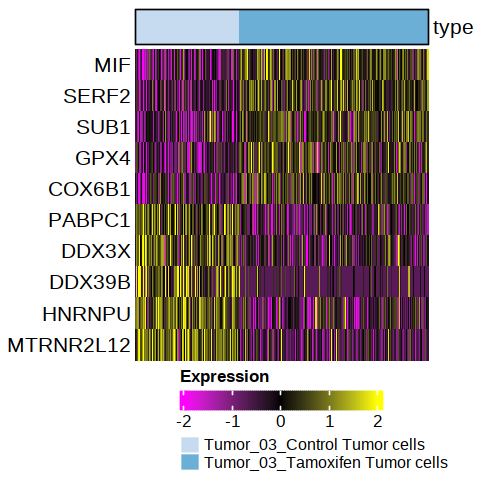

Tumor_07_Tamoxifen pattern_tumor_epi

assay=integrated, slot=data

Tumor_07_Tamoxifen Tumor cells n_idx1: 157, samples: Tumor_07_Tamoxifen

Tumor_07_Control Tumor cells n_idx_ref: 77, samples: Tumor_07_Control

seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPS10,3.351304e-22,0.9639072,0.968,0.857,8.604809e-18,-0.03638686,1.1902029,2.050928
PSMA2,2.297688e-13,0.5930006,0.911,0.636,5.899545e-09,-0.17846608,0.6058180,1.680794
PLPP5,1.563610e-08,0.5383535,0.866,0.636,4.014725e-04,-0.69898403,0.6731184,2.098518


[1] 3 8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MTRNR2L12,1.407432e-16,-1.1136381,0.796,0.974,3.613722e-12,-1.0222208,0.471827045,1.8472606
MIF,2.372502e-15,-1.2778079,0.860,0.948,6.091636e-11,0.0000000,1.108223285,1.9623582
NME2,2.549321e-15,-0.5544585,0.369,0.727,6.545637e-11,-0.1843688,0.052683801,0.5299139
HIST2H2AA4,7.110885e-13,-0.6524953,0.369,0.740,1.825791e-08,-0.1082788,0.067873514,0.8502978
IGKC,1.789234e-12,-0.4519582,0.382,0.792,4.594036e-08,-0.4406996,0.006072373,1.4623880
PLCG2,9.432728e-12,-2.1108720,0.318,0.766,2.421947e-07,-1.4671279,-0.051282338,2.4630054


[1] 16  8

up h

up unc_lccc

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<int>
HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_FATTY_ACID_METABOLISM,1/1,158/4386,0.03602371,0.04559964,NA,MIF,1
HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,1/1,200/4386,0.04559964,0.04559964,NA,MIF,1
HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,1/1,200/4386,0.04559964,0.04559964,NA,MIF,1


[1] 3 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,4/13,50/19993,2.433482e-08,1.168072e-06,6.403901e-07,RPL37A/RPS29/RPL38/RPS28,4
IgG_Breast.Cancer.Research.2008_PMID.19272155,IgG_Breast.Cancer.Research.2008_PMID.19272155,IgG_Breast.Cancer.Research.2008_PMID.19272155,3/13,21/19993,2.837046e-07,6.808909e-06,3.732955e-06,IGKC/IGHA1/IGLC2,3
JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,3/13,35/19993,1.388807e-06,2.222091e-05,1.218252e-05,NME2/RPS29/RPL38,3
Miller_B_P_Metagene_Genome_Biol_2013_PMID.23618380,Miller_B_P_Metagene_Genome_Biol_2013_PMID.23618380,Miller_B_P_Metagene_Genome_Biol_2013_PMID.23618380,2/13,15/19993,4.078574e-05,4.894289e-04,2.683272e-04,IGKC/IGHA1,2
IMMUNE_Bindea_Cell_B_cells_Immunity.2013_PMID.24138885,IMMUNE_Bindea_Cell_B_cells_Immunity.2013_PMID.24138885,IMMUNE_Bindea_Cell_B_cells_Immunity.2013_PMID.24138885,2/13,33/19993,2.037442e-04,1.955945e-03,1.072338e-03,IGKC/IGHA1,2
Inflammatory_Breast_Cancer_491_IBC_CCR.2013_PMID.23396049,Inflammatory_Breast_Cancer_491_IBC_CCR.2013_PMID.23396049,Inflammatory_Breast_Cancer_491_IBC_CCR.2013_PMID.23396049,3/13,199/19993,2.581031e-04,2.064825e-03,1.132031e-03,PLCG2/RPL37A/RPL38,3


[1] 10  9

filename_xlsx: xlsx/er+bc_Tumor_07_Control_vs_Tumor_07_Tamoxifen_Tumor_cells.xlsx

filename_figure: heatmap_er+bc_Tumor_07_Control_vs_Tumor_07_Tamoxifen_Tumor_cells_no_down_mcf7.e2.induced.genes_zscore

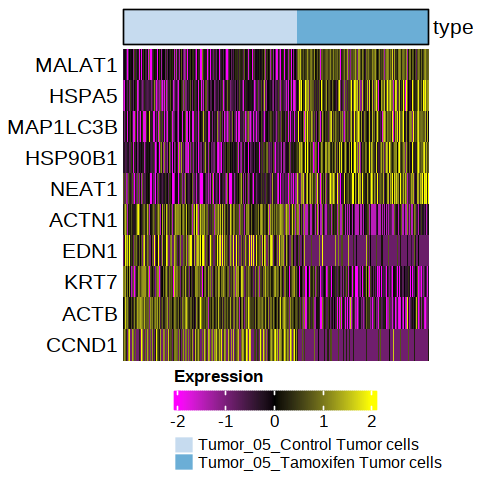

Tumor_08_Tamoxifen pattern_tumor_epi

assay=integrated, slot=data

Tumor_08_Tamoxifen Tumor cells n_idx1: 682, samples: Tumor_08_Tamoxifen

Tumor_08_Control Tumor cells n_idx_ref: 743, samples: Tumor_08_Control

seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CDC42SE1,2.974181e-57,0.6568836,0.941,0.688,7.636507e-53,-0.92475319,0.9090348,2.104937
MT2A,3.382202e-56,1.1555258,0.849,0.511,8.684142e-52,-0.58447406,0.9996416,4.730844
C1orf56,1.086058e-45,0.6251147,0.855,0.565,2.788561e-41,-1.17519183,0.6327276,2.063473
ARF6,9.264250e-45,0.5223942,0.956,0.863,2.378689e-40,-0.09835825,1.1260169,2.374949
SCD,6.187217e-44,0.4646426,0.685,0.334,1.588630e-39,-0.27900688,0.4546321,2.180458
CTNNB1,6.193973e-33,0.4264701,0.969,0.813,1.590364e-28,-0.72479255,1.0581664,2.220494


[1] 58  8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MT-ATP6,6.141741e-47,-0.4708075,1.000,0.999,1.576953e-42,0.004864608,2.7584547,4.028168
VMP1,3.558260e-26,-0.4667878,0.969,0.984,9.136187e-22,-0.308609868,1.0807997,3.145889
MT-ND6,1.981361e-24,-0.4036575,0.632,0.821,5.087342e-20,-0.656297507,0.3385778,2.022088
CDV3,4.655248e-24,-0.4110715,0.792,0.894,1.195281e-19,0.000000000,0.8929374,2.283976
MT-ND2,5.764594e-24,-0.3490272,0.984,0.992,1.480117e-19,-0.641426681,1.4203234,2.917836
NPM1,1.450289e-23,-0.3896005,0.993,0.999,3.723761e-19,0.000000000,2.1694268,3.456115


[1] 33  8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,8/37,74/4386,1.165715e-07,4.196573e-06,3.435791e-06,SCD/CTNNB1/IDI1/FASN/SQLE/FDPS/FDFT1/LDLR,8
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,11/37,200/4386,4.061700e-07,7.311061e-06,5.985664e-06,SCD/IDI1/SQSTM1/SQLE/CALR/EIF2S2/INSIG1/LDLR/NUPR1/DHCR24/STC1,11
HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,6/37,101/4386,1.674353e-04,2.009223e-03,1.644978e-03,SCD/IDI1/INSIG1/DBI/DHCR24/AZGP1,6
HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY,7/37,200/4386,1.182009e-03,8.510465e-03,6.967632e-03,FASN/AMFR/SFN/TFF3/FDFT1/TFF1/MUC1,7
HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ESTROGEN_RESPONSE_LATE,7/37,200/4386,1.182009e-03,8.510465e-03,6.967632e-03,AMFR/SFN/TFF3/FDFT1/TFF1/S100A9/LSR,7


[1] 5 9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,12/57,290/19993,2.733144e-11,3.281036e-09,2.201273e-09,ARF6/SCD/IDI1/FASN/SQLE/AMFR/MSMO1/EIF2S2/INSIG1/FDFT1/LDLR/TFF1,12
UNC_HS_Red12_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red12_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red12_BMC.Med.Genomics.2011_PMID.21214954,12/57,297/19993,3.605534e-11,3.281036e-09,2.201273e-09,MT2A/SCD/TMSB10/TMC5/MSMO1/S100P/DBI/CEACAM6/NUPR1/DUSP4/DHCR24/S100A9,12
UNC_HS_Red25_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red25_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red25_BMC.Med.Genomics.2011_PMID.21214954,9/57,143/19993,2.554331e-10,1.414034e-08,9.486868e-09,SCD/GDF15/CEACAM5/TFF3/S100P/HSPB1/CEACAM6/TFF1/STC1,9
GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,11/57,277/19993,3.107767e-10,1.414034e-08,9.486868e-09,MT2A/FASN/CLDN4/TACSTD2/TFF3/TMC5/S100P/HSPB1/CEACAM6/TFF1/S100A9,11
UNC_HS_Red19_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red19_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red19_BMC.Med.Genomics.2011_PMID.21214954,10/57,216/19993,4.877252e-10,1.775320e-08,1.191076e-08,GDF15/CEACAM5/TFF3/CEACAM6/CST3/TFF1/TIMP1/DUSP4/AZGP1/LSR,10
UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green8_BMC.Med.Genomics.2011_PMID.21214954,10/57,314/19993,1.778931e-08,5.396092e-07,3.620282e-07,FASN/GDF15/TFF3/TMC5/CEACAM6/TFF1/MUC1/DUSP4/DHCR24/AZGP1,10


[1] 45  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,5/10,200/4386,3.92099e-05,0.0005097287,0.0004540093,NPM1/HSP90AB1/PSMA2/SRSF7/PTGES3,5


[1] 1 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,7/28,107/19993,1.112607e-10,7.009424e-09,5.387360e-09,MT-ATP6/CDV3/MT-ND2/MT-CO3/MT-CYB/PSMA2/SRSF7,7
UNC_MUnknown_6_BMC.Med.Genomics.2011_PMID.21214954,UNC_MUnknown_6_BMC.Med.Genomics.2011_PMID.21214954,UNC_MUnknown_6_BMC.Med.Genomics.2011_PMID.21214954,5/28,151/19993,1.964395e-06,6.187845e-05,4.755904e-05,NPM1/RPL27A/PTGES3/TOMM20/NIFK,5
MITO2_BMC.Med.Genomics.2011_PMID.21214954,MITO2_BMC.Med.Genomics.2011_PMID.21214954,MITO2_BMC.Med.Genomics.2011_PMID.21214954,3/28,78/19993,1.744353e-04,3.663141e-03,2.815446e-03,PSMA2/PSMA3/PSMA5,3
HER1_Cluster3_BMC.Genomics.2007_PMID.17663798,HER1_Cluster3_BMC.Genomics.2007_PMID.17663798,HER1_Cluster3_BMC.Genomics.2007_PMID.17663798,3/28,135/19993,8.716705e-04,1.314227e-02,1.010099e-02,SRSF7/DCAF13/TRMT10C,3
Duke_Module13_myc_Mike_PMID.20335537,Duke_Module13_myc_Mike_PMID.20335537,Duke_Module13_myc_Mike_PMID.20335537,4/28,326/19993,1.043037e-03,1.314227e-02,1.010099e-02,NPM1/HSP90AB1/SRSF7/PTGES3,4
Inflammatory_Breast_Cancer_79_IBC_CCR.2013_PMID.23396049,Inflammatory_Breast_Cancer_79_IBC_CCR.2013_PMID.23396049,Inflammatory_Breast_Cancer_79_IBC_CCR.2013_PMID.23396049,2/28,43/19993,1.648359e-03,1.730777e-02,1.330255e-02,RPL27A/SRSF7,2


[1] 8 9

filename_xlsx: xlsx/er+bc_Tumor_08_Control_vs_Tumor_08_Tamoxifen_Tumor_cells.xlsx

filename_figure: heatmap_er+bc_Tumor_08_Control_vs_Tumor_08_Tamoxifen_Tumor_cells_no_down_mcf7.e2.induced.genes_zscore

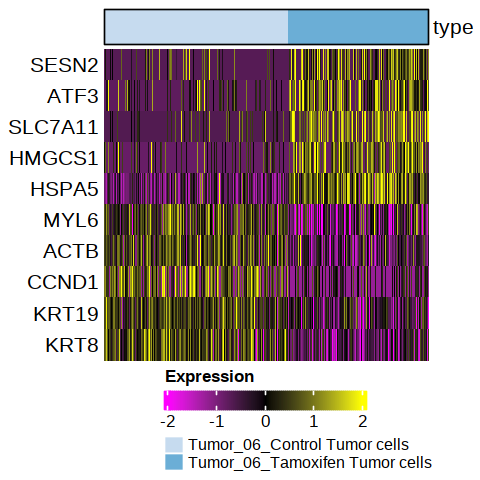

Tumor_09_Tamoxifen pattern_tumor_epi

assay=integrated, slot=data

Tumor_09_Tamoxifen Tumor cells n_idx1: 533, samples: Tumor_09_Tamoxifen

Tumor_09_Control Tumor cells n_idx_ref: 540, samples: Tumor_09_Control

seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPS10,6.710962e-40,0.5113749,0.968,0.876,1.723107e-35,0.0000000,1.1399854,2.009932
RABGGTB,8.562451e-29,0.4151299,0.805,0.507,2.198495e-24,0.0000000,0.6231319,2.106980
PSMA2,2.481379e-28,0.3897187,0.839,0.672,6.371188e-24,-0.4090280,0.4982637,1.798154
OSTC,3.032506e-25,0.4335156,0.953,0.900,7.786263e-21,-0.3593134,1.0506811,2.681391
RPL9,6.252918e-24,0.2788291,0.991,0.987,1.605499e-19,0.0000000,2.8950483,3.885432
MYDGF,4.746301e-21,0.3620861,0.972,0.961,1.218660e-16,-0.1701983,1.3006470,2.723822


[1] 65  8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ATP5F1E,1.731359e-102,-0.7801280,0.991,0.996,4.445436e-98,-0.1767889,1.7302708,2.659704
RPS29,7.186275e-99,-1.0022941,0.983,0.985,1.845148e-94,0.0000000,2.1108794,3.256736
RPL37A,3.909152e-96,-0.9137705,0.989,0.996,1.003714e-91,0.0000000,2.3257554,3.499934
PLCG2,9.247189e-94,-1.7736459,0.323,0.861,2.374308e-89,-1.6264090,-0.2244313,2.453961
RPL37,5.597670e-91,-0.8227433,0.998,1.000,1.437258e-86,0.0000000,2.2183963,3.193978
RPS27,2.253315e-87,-0.8058591,0.994,1.000,5.785612e-83,0.0000000,2.8289573,4.142486


[1] 122   8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,7/36,200/4386,0.0009962374,0.03486831,0.02936279,ZFP36/DDIT3/MT2A/MT1E/PPP1R15A/HSPA5/HMOX1,7
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,5/36,113/4386,0.0020692003,0.03621101,0.03049348,SERP1/NPM1/TUBB2A/HERPUD1/HSPA5,5


[1] 2 9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,8/60,290/19993,2.367585e-06,0.0002510754,0.0002122036,SERP1/DDIT3/TRIB3/SLC3A2/PPP1R15A/HERPUD1/HSPA5/HMOX1,8
MITO2_BMC.Med.Genomics.2011_PMID.21214954,MITO2_BMC.Med.Genomics.2011_PMID.21214954,MITO2_BMC.Med.Genomics.2011_PMID.21214954,5/60,78/19993,3.665335e-06,0.0002510754,0.0002122036,PSMA2/NDUFAB1/GTF2A2/TMEM59/NDUFB3,5
Shipitsin_CD44_A_Cancer.Cell.2007_PMID.17349583,Shipitsin_CD44_A_Cancer.Cell.2007_PMID.17349583,Shipitsin_CD44_A_Cancer.Cell.2007_PMID.17349583,4/60,41/19993,6.829439e-06,0.0003118777,0.0002635924,FTL/MT2A/H2AFZ/KDELR2,4
Duke_Module18_ras_Mike_PMID.20335537,Duke_Module18_ras_Mike_PMID.20335537,Duke_Module18_ras_Mike_PMID.20335537,6/60,168/19993,1.107119e-05,0.0003791882,0.0003204818,MT2A/EEF1E1/H2AFZ/MT1E/HERPUD1/PHLDA2,6
UNC_MM_Green15_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Green15_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Green15_BMC.Med.Genomics.2011_PMID.21214954,6/60,218/19993,4.806963e-05,0.0013171079,0.0011131915,FTL/SEC61B/MT2A/CSTB/HSPA5/PHLDA2,6
Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,3/60,27/19993,7.140041e-05,0.0016303093,0.0013779026,MAP1LC3B/SLC3A2/HERPUD1,3


[1] 13  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,9/39,200/4386,4.580168e-05,0.0006870252,0.000650866,RPL34/EIF3J/PA2G4/DDX21/RPL22/DDX18/SNRPG/VDAC1/SET,9
HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,9/39,200/4386,4.580168e-05,0.0006870252,0.000650866,NDUFA1/NDUFB1/COX7C/NDUFA3/UQCR11/COX17/UQCRQ/NDUFC1/VDAC1,9


[1] 2 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Ribosomal_Cluster_BMC.Med.Genomics.2011_PMID.21214954,13/110,50/19993,6.102108e-19,1.116686e-16,9.699141e-17,RPS29/RPL37A/RPL37/RPS28/RPL36/RPL38/RPS21/RPL39/RPL35/RPLP2/RPL35A/RPL31/RPS8,13
JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,JANES_Oscillation_JUND_KRT5_Nat.Cell.Biol.2014_PMID.24658685,9/110,35/19993,2.074175e-13,1.897870e-11,1.648423e-11,RPS29/RPL38/RPS21/NDUFA1/ELOB/SLIRP/TMEM258/S100A6/ADIRF,9
MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,8/110,38/19993,2.764934e-11,1.686610e-09,1.464930e-09,TMA7/NDUFB1/COX7C/TMEM258/UQCR11/COX17/UQCRQ/NDUFC1,8
MRibosomal_BMC.Med.Genomics.2011_PMID.21214954,MRibosomal_BMC.Med.Genomics.2011_PMID.21214954,MRibosomal_BMC.Med.Genomics.2011_PMID.21214954,5/110,23/19993,1.430409e-07,6.544121e-06,5.683993e-06,RPL36/RPL39/RPL35/RPL41/RPS17,5
MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,8/110,290/19993,2.029558e-04,7.428183e-03,6.451859e-03,COPS9/GREB1/TPM3/C8orf33/TPM1/HIF1A/ACTN1/SPATS2L,8
Duke_Module13_myc_Mike_PMID.20335537,Duke_Module13_myc_Mike_PMID.20335537,Duke_Module13_myc_Mike_PMID.20335537,8/110,326/19993,4.446429e-04,1.356161e-02,1.177914e-02,EIF3J/EIF5B/PA2G4/DDX21/DDX18/VDAC1/PTMA/SET,8


[1] 12  9

filename_xlsx: xlsx/er+bc_Tumor_09_Control_vs_Tumor_09_Tamoxifen_Tumor_cells.xlsx

filename_figure: heatmap_er+bc_Tumor_09_Control_vs_Tumor_09_Tamoxifen_Tumor_cells_zscore

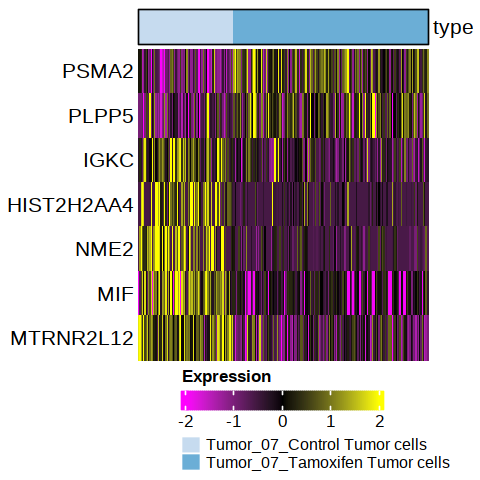

Tumor_10_Tamoxifen pattern_tumor_epi

assay=integrated, slot=data

Tumor_10_Tamoxifen Tumor cells n_idx1: 43, samples: Tumor_10_Tamoxifen

Tumor_10_Control Tumor cells n_idx_ref: 192, samples: Tumor_10_Control

seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MTRNR2L12,3.588937e-20,2.3057234,1.000,0.688,9.214954e-16,0.15584324,2.0136075,3.564451
PLCG2,7.742078e-14,1.7262956,0.930,0.370,1.987856e-09,-0.10353670,1.0729859,3.944075
MTRNR2L1,1.103076e-08,0.7922572,0.767,0.286,2.832258e-04,-0.29979209,0.5104909,1.847009
HES1,6.114435e-08,0.8837667,0.860,0.521,1.569942e-03,-0.04778027,1.0394199,2.412350
GOLGB1,9.381748e-08,0.7759146,0.953,0.906,2.408858e-03,0.00000000,1.5111767,2.563412
MTRNR2L8,1.481336e-07,0.8972956,0.791,0.417,3.803480e-03,-0.20010434,0.6938094,2.825096


[1] 8 8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CDC42,1.778246e-08,-0.6943343,0.907,0.984,0.0004565823,0,1.051764,1.825086


[1] 1 8

up h

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
UNC_Unknown_4_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_4_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_4_BMC.Med.Genomics.2011_PMID.21214954,2/5,68/19993,0.0001132347,0.003057336,0.001430333,GOLGB1/GOLGA4,2
Mouse_Human_ImmuneProfiles_SHAY_M_H_Induced_in_B_PNAS.2013_PMID.23382184,Mouse_Human_ImmuneProfiles_SHAY_M_H_Induced_in_B_PNAS.2013_PMID.23382184,Mouse_Human_ImmuneProfiles_SHAY_M_H_Induced_in_B_PNAS.2013_PMID.23382184,2/5,171/19993,0.0007150759,0.009653524,0.004516269,PLCG2/HES1,2
UNC_HS_Green16_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green16_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green16_BMC.Med.Genomics.2011_PMID.21214954,2/5,276/19993,0.0018474012,0.016626611,0.007778531,GOLGB1/GOLGA4,2
MIR_200c_Induced_ONCO.2015_PMID.25746005,MIR_200c_Induced_ONCO.2015_PMID.25746005,MIR_200c_Induced_ONCO.2015_PMID.25746005,2/5,491/19993,0.0057301457,0.034782659,0.016272589,PLCG2/GOLGA4,2
Bcell_IL10_MINUS_LIN_J_Immunol.2014_PMID.25080484,Bcell_IL10_MINUS_LIN_J_Immunol.2014_PMID.25080484,Bcell_IL10_MINUS_LIN_J_Immunol.2014_PMID.25080484,1/5,27/19993,0.0067348221,0.034782659,0.016272589,HES1,1
IMMUNE_Bindea_Cell_Eosinophils_Immunity.2013_PMID.24138885,IMMUNE_Bindea_Cell_Eosinophils_Immunity.2013_PMID.24138885,IMMUNE_Bindea_Cell_Eosinophils_Immunity.2013_PMID.24138885,1/5,31/19993,0.0077294797,0.034782659,0.016272589,HES1,1


[1] 9 9

down h

down unc_lccc

filename_xlsx: xlsx/er+bc_Tumor_10_Control_vs_Tumor_10_Tamoxifen_Tumor_cells.xlsx

filename_figure: heatmap_er+bc_Tumor_10_Control_vs_Tumor_10_Tamoxifen_Tumor_cells_no_down_mcf7.e2.induced.genes_zscore

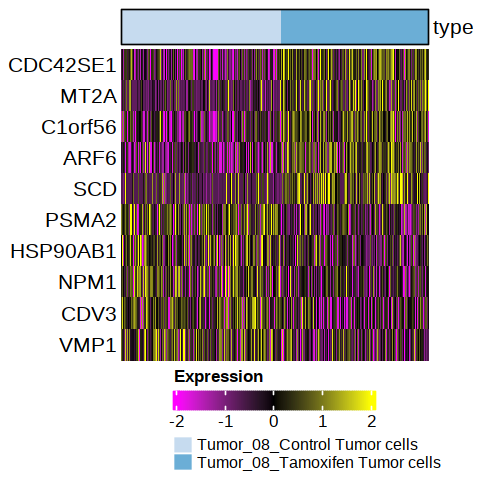

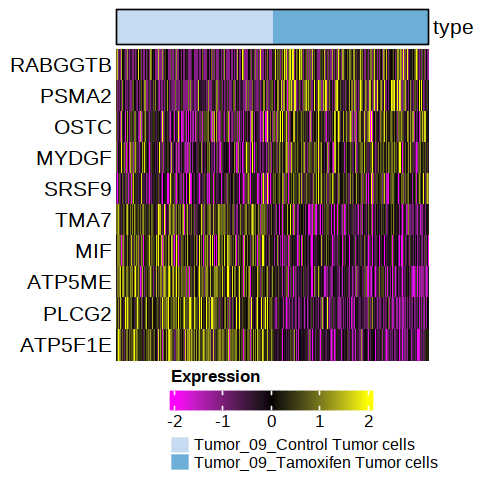

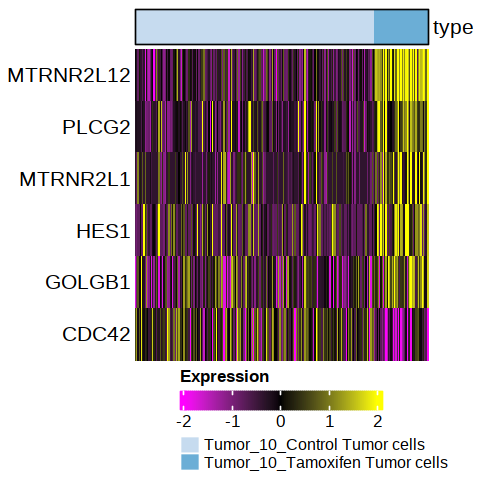

In [20]:
cell_types <- c("pattern_tumor_epi")
collections <- names(list_gmt)

df_info <- data.frame()


for (i in seq(list_samples)) {
    
  sample1 <- list_samples[[i]]$treatment
  sample_ref <- list_samples[[i]]$control
    
  th_log2fc_=0.25; th_padj_=0.01
    
  min.pct_=0.25
  min.diff.pct_=-Inf
  max.cells.per.ident_=Inf
    
  f_featureplot=FALSE
  n_sampling=-1
  cluster_rows=FALSE

  drug_name <- "tamoxifen"
  pattern_sample1 <- NULL
  pattern_sample_ref <- NULL

  group_name1 <- sample1
  group_name_ref <- sample_ref
    
  col_cluster_types_ <- NULL
  col_cell_types_ <- "cell.type"  

  for (cell_type in cell_types) {
    
    display_html("<hr style=\"height:2px\">")
    log_txt(sprintf("%s %s", group_name1, cell_type))
    
    cell_type_ <- cell_type
    pattern_cell_type_ <- NULL
    switch(cell_type,
          "pattern_tumor_epi"={
              cell_type_ = NULL
              cell_type <- "Tumor cells"
              pattern_cell_type_ <- pattern_tumor_epi
          },
          {}
    ) # switch
      
    list_markers <- find_markers(rna,
                        #assay = "RNA", slot = "data",
                        sample1 = sample1,
                        sample_ref = sample_ref,
                        pattern_sample1 = pattern_sample1,
                        pattern_sample_ref = pattern_sample_ref,
                        cell_type1 = cell_type_,
                        cell_type_ref = cell_type_,
                                 
                        # pattern_cell_type         
                        pattern_cell_type1 = pattern_cell_type_,
                        pattern_cell_type_ref = pattern_cell_type_,         
                                 
                        genes = genes,
                        str_cond1 = str_cond1,
                        str_cond_ref = str_cond_ref,
                                 
                        group_name1 = sprintf("%s %s", group_name1, cell_type),
                        group_name_ref = sprintf("%s %s", group_name_ref, cell_type),
                        col_cluster_types = col_cluster_types_,
                        col_cell_types = col_cell_types_,
                            
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_, 
                        min.pct = min.pct_,
                        min.diff.pct = min.diff.pct_,
                        max.cells.per.ident = max.cells.per.ident_,
                        method_dge = method_dge,
                        n_log = 1)

  if (!is.null(list_markers)) {
    
    str_condition_tmp <- sprintf("%s_%s_vs_%s_%s",
                               str_condition,
                               group_name_ref, group_name1,
                               cell_type)
    if (type_condition != "none") {
          str_condition_tmp <- sprintf("%s_%s", str_condition_tmp, type_condition)
    }
      
    list_ea <- execute_enrichment_analysis(list_markers,
                        str_condition_tmp,
                        collections = collections,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_,
                        th_enricher_padj=0.05,
                        th_enricher_qval=0.05,   
                        method_dge = method_dge,
                        dir_xlsx = dir_xlsx,       
                        n_log = 1)


    genes_up <- rownames(list_ea$df_up)
    genes_dn <- rownames(list_ea$df_dn)
    list_genes_dn[[cell_type]] <- genes_dn

    if (f_featureplot) {
      gg <- featureplot_enrichment_analysis(rna,
                list_ea,
                str_condition_tmp)
    }

    str_condition_tmp_ <- str_condition_tmp
    unlink(sprintf("%s/%s*", figure_format, str_condition_tmp))
    df_dp <- as.data.frame(list_ea[[tab_check]])
    if (any(grepl("MCF7.E2.induced.genes", rownames(df_dp)))) {
        df_info[cell_type, sample1] <- "E2IG down"
    } else {    
        str_condition_tmp_ <- sprintf("%s_no_down_mcf7.e2.induced.genes", str_condition_tmp)
    }
    list_out_heatmap <- heatmap_enrichment_analysis(list_markers,
                    list_ea,
                    str_condition_tmp_,
                    pattern_gene_removal="^MT-|^RPS|^RPL",
                    max_up=5, max_dn=5,
                    n_sampling=n_sampling,
                    cluster_rows=cluster_rows)
  } # if
} # for cell type
} # for list_samples    




# session info

In [21]:
writeLines(capture.output(sessionInfo()), "txt/sessionInfo.txt")


# reference

https://satijalab.org/seurat/

